In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t, multivariate_normal,chi2
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
import pandas as pd
import seaborn as sns
import datetime
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')
import DyGraph as dg
import pickle
from sklearn.datasets import make_sparse_spd_matrix
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray
import port_measures as pm
from collections import defaultdict
import scipy.integrate as integrate
from sklearn.covariance import LedoitWolf
from multiprocessing.pool import Pool

In [2]:
with open(f'../data/case_study_etf/skew-group-t_nr_quad_10_etf_static_l_20_outer_em.pkl', 'rb') as handle:
    static_sgt_port = pickle.load(handle)

In [10]:
with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static_l_20_outer_em.pkl', 'rb') as handle:
    static_sgt_port = pickle.load(handle)

X = np.array(static_gt_port['X'].iloc[:500])
mu = np.mean(X, 0)

dg_opt = dg.sgl_outer_em(max_iter = 10, lamda = 500*0.05, tol = 1e-3)
dg_opt.fit(X-mu,  lik_type='skew-group-t', nu = None, verbose=True, nr_workers = 12, 
            max_admm_iter = 100, groups = static_sgt_port['groups'], nr_quad = 10)

Error 1.77E-3:  50%|█████     | 5/10 [03:09<03:09, 37.96s/it]


In [15]:
with open(f'../data/case_study_etf/skew-group-t_nr_quad_10_etf_static_l_20_outer_em.pkl', 'rb') as handle:
    static_sgt_port = pickle.load(handle)

In [12]:
dg_opt2 = dg.sgl_outer_em(max_iter = 10, lamda = 500*0.05, tol = 1e-3)
dg_opt2.fit(X-mu,  lik_type='skew-group-t', nu = None, verbose=True, nr_workers = 12, 
            max_admm_iter = 100, groups = static_sgt_port['groups'], nr_quad = 10, theta_init=dg_opt.theta)

  0%|          | 0/10 [00:33<?, ?it/s]


In [13]:
dg_opt2.gamma

array([[0.00033247, 0.00027873, 0.00027711, 0.00031219, 0.00024889,
        0.00030621, 0.00012121, 0.00023937, 0.00018502, 0.00026623,
        0.00035832]])

# Synthetic experiment, simulate t distributed assets

In [141]:
mu = np.array([0.05, -0.03, 0.03, 0.01])*(1/100)
prec_2 = np.array([[ 11256.86,  -4628.13,    0,  -3478.66],
                    [ -4628.13,  20616.77,  -2612.78, -10453.99],
                    [     0,  -2612.78,   5134.58,  0],
                    [ -3478.66, -10453.99,  0,  17254.62]])

print(np.linalg.cond(prec_2))
np.linalg.inv(prec_2)


X = multivariate_t.rvs(loc = mu, shape = np.linalg.inv(prec_2), df = 4, size = 10001)
price = np.cumprod(1+X, axis = 0)
X = X[1:]



10.087999048502667


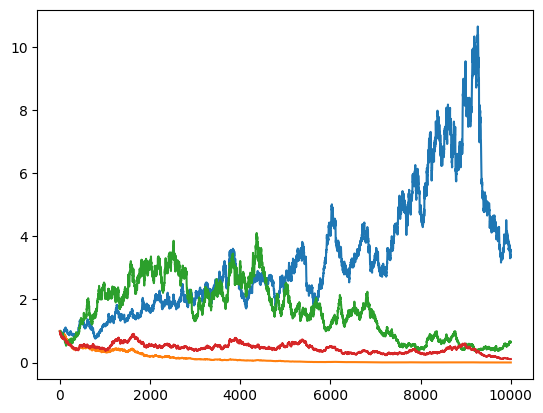

In [157]:
plt.plot(price)

In [65]:
# import requests
# import yfinance as yf
# import pickle
# ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
# groups_according_to_ticker = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
# start_date= "2016-01-01"
# end_date="2023-02-01"

# data = yf.download(ticker_list, start_date , end_date)
# returns = data['Adj Close'].pct_change().dropna()
# log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = data['Adj Close'].iloc[1:]
# groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))]) 

[*********************100%***********************]  11 of 11 completed


In [155]:
alphas = [0.025, 0.05,0.075, 0.1, 0.4]
omega_t = {i:[] for i in range(len(alphas))}
omega_g = {i:[] for i in range(len(alphas))}
sharpe_t = {i:[] for i in range(len(alphas))}
sharpe_g = {i:[] for i in range(len(alphas))}
mdd_t = {i:[] for i in range(len(alphas))}
mdd_g = {i:[] for i in range(len(alphas))}

obs_per_graph = 500
tol = 1e-4
max_iter = 1000

time_index = range(obs_per_graph, obs_per_graph + 1000, 20)
pbar = tqdm.tqdm(total = len(time_index)*len(alphas), position=0)
X_scaled = X.copy()*100
for cnt, alpha in enumerate(alphas):
    for i in time_index:
        X_now = X_scaled[i-obs_per_graph:i].copy()

        mu_est = np.mean(X_scaled[i-obs_per_graph:i], axis = 0)

        # t
        dg_opt = dg.sgl(max_iter = max_iter, lamda = obs_per_graph*alpha, tol = tol)
        dg_opt.fit(np.array(X_now-mu_est),  lik_type='t', nu = None,verbose=False, 
                theta_init= None)
                      
        # get precision/covariance
        precision_matrix = dg_opt.theta[-1].copy()
        precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
        S = np.linalg.inv(precision_matrix)
        gamma = dg_opt.gamma[-1].copy()
        C = (dg_opt.nu[-1]/(dg_opt.nu[-1]-2))
        S = C*S

        # Update precision matrix 
        precision_matrix = np.linalg.inv(S) 
        # portfolio weights sharpe
        w_s, mu_s, var_s = pm.portfolio_opt(S, precision_matrix, mu, X_now, type = 'gmv', w_fix=False)
        portfolio_s = np.dot(price[i:i+20],w_s)
        log_returns_s = np.dot(X_scaled[i:i+20],w_s) # np.dot(np.array(price.iloc[i:i + l]),w_s)
        r_s = portfolio_s[-1]/portfolio_s[0] - 1
        sigma_s = np.std(log_returns_s)
        sharpe_s = pm.sharpe(r_s,sigma_s)
        sharpe_t[cnt].append(sharpe_s)
        mdd_t[cnt].append(pm.max_drawdown(portfolio_s))
        omega_t[cnt].append(pm.omega(np.squeeze(log_returns_s)))

        # Gaussian
        
        dg_opt_n = dg.sgl(max_iter = max_iter, lamda = obs_per_graph*alpha, tol = tol)
        dg_opt_n.fit(np.array(X_now-mu_est),  lik_type='gaussian', nu = None,verbose=False, 
                theta_init= None)
                      
        # get precision/covariance
        precision_matrix = dg_opt_n.theta[-1].copy()
        precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
        S_gaussian = np.linalg.inv(precision_matrix)

        # Update precision matrix 
        precision_matrix = np.linalg.inv(S_gaussian) 
        # portfolio weights sharpe
        w_s, mu_s, var_s = pm.portfolio_opt(S_gaussian, precision_matrix, mu, X_now, type = 'gmv', w_fix=False)
        portfolio_s = np.dot(price[i:i+20],w_s)
        log_returns_s = np.dot(X_scaled[i:i+20],w_s) # np.dot(np.array(price.iloc[i:i + l]),w_s)
        r_s = portfolio_s[-1]/portfolio_s[0] - 1
        sigma_s = np.std(log_returns_s)
        sharpe_s = pm.sharpe(r_s,sigma_s)
        sharpe_g[cnt].append(sharpe_s)
        mdd_g[cnt].append(pm.max_drawdown(portfolio_s))
        omega_g[cnt].append(pm.omega(np.squeeze(log_returns_s)))




        pbar.update()

pbar.close()





100%|██████████| 250/250 [00:18<00:00, 13.77it/s]


In [144]:

i = 1000
dg_opt_n = dg.sgl(max_iter = max_iter, lamda = obs_per_graph*0.025, tol = tol)
dg_opt_n.fit(np.array(X_scaled[i-500:i]-mu_est),  lik_type='t', nu = None,verbose=False, 
        theta_init= None)
                
# get precision/covariance
precision_matrix = dg_opt_n.theta[-1].copy()
precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
S_gaussian = np.linalg.inv(precision_matrix)

# Update precision matrix 
precision_matrix = np.linalg.inv(S_gaussian) 
# portfolio weights sharpe
w_s, mu_s, var_s = pm.portfolio_opt(S_gaussian, precision_matrix, mu, X[i-500:i], type = 'sharpe', w_fix=False)
portfolio_s = np.dot(price[i:i+20],w_s)
log_returns_s = np.dot(X[i:i+20],w_s) # np.dot(np.array(price.iloc[i:i + l]),w_s)
r_s = portfolio_s[-1]/portfolio_s[0] - 1
sigma_s = np.std(log_returns_s)
sharpe_s = pm.sharpe(r_s,sigma_s)

Text(0.5, 1.0, 'Sharpe')

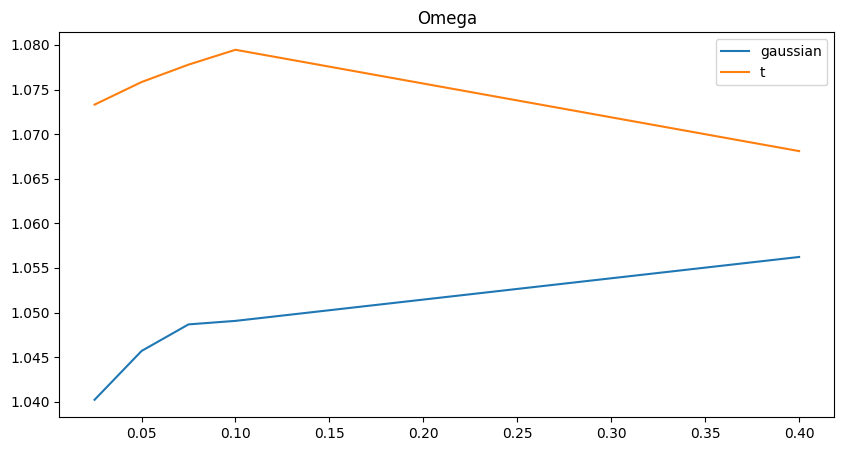

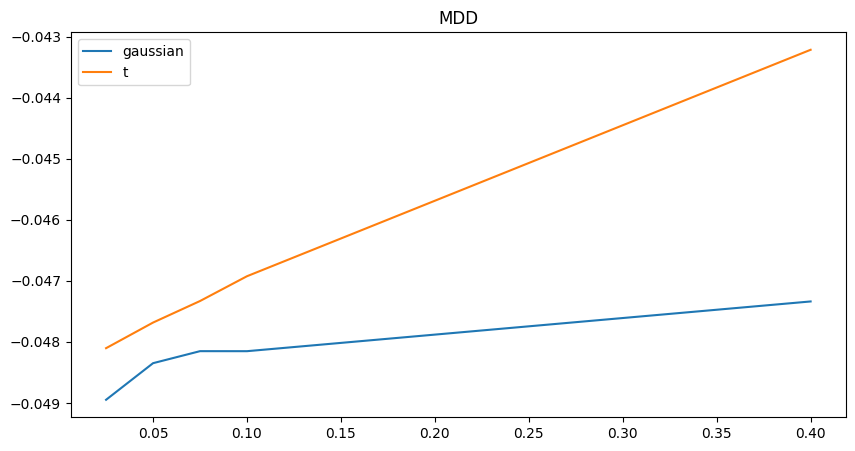

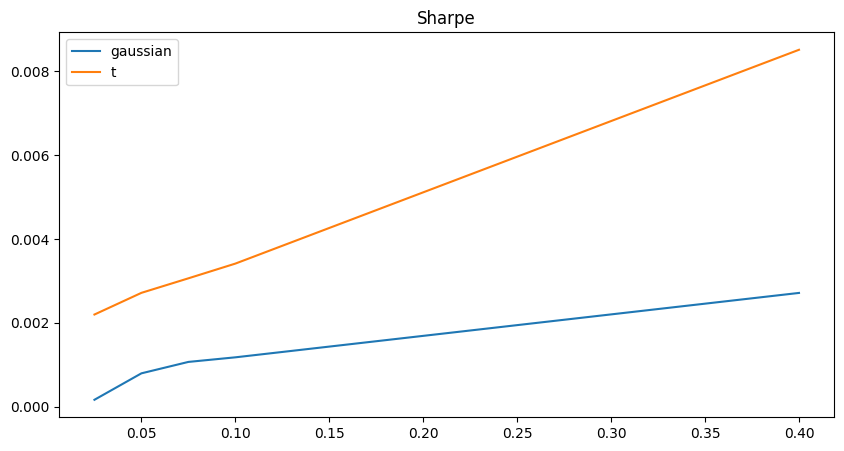

In [156]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, [np.median(omega_g[i]) for i in range(len(omega_g))], label = 'gaussian')
ax.plot(alphas, [np.median(omega_t[i]) for i in range(len(omega_t))], label = 't')
ax.legend()
ax.set_title("Omega")

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, [np.median(mdd_g[i]) for i in range(len(mdd_g))], label = 'gaussian')
ax.plot(alphas, [np.median(mdd_t[i]) for i in range(len(mdd_t))], label = 't')
ax.legend()
ax.set_title("MDD")

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, [np.median(sharpe_g[i]) for i in range(len(sharpe_g))], label = 'gaussian')
ax.plot(alphas, [np.median(sharpe_t[i]) for i in range(len(sharpe_t))], label = 't')
ax.legend()
ax.set_title("Sharpe")

# Create Raw data

In [2]:
# import requests
# import yfinance as yf
# import pickle
# ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
# groups_according_to_ticker = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
# start_date= "2016-01-01"
# end_date="2023-02-01"

# data = yf.download(ticker_list, start_date , end_date)
# returns = data['Adj Close'].pct_change().dropna()
# log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = data['Adj Close'].iloc[1:]
# groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

# gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,'returns':returns,
#         'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

            
# with open(f'../data/case_study_etf/raw_etf.pkl', 'wb') as handle:
#         pickle.dump(gogn, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [414]:
# import requests
# response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" )
# ticker_data = pd.read_html(response.content)[0]
# ticker_data['group'] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
# ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2


# rndstate = np.random.RandomState(6)
# index = rndstate.choice(np.array(range(500)),size = 100,replace=False)
# ticker_list = np.array(ticker_data['Symbol'].iloc[index]).tolist()
# groups_according_to_ticker = np.array(ticker_data['group'].iloc[index])

# start_date= "2016-01-01"
# end_date="2023-02-01"

# import yfinance as yf
# data = yf.download(ticker_list, start_date , end_date)
# dd = data['Adj Close'].dropna(axis=1)

# log_returns = np.log(1+dd.pct_change()).dropna()
# returns = dd.pct_change().copy()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = dd.iloc[1:]

# # reorder groups according to log_returns scaled as they are in alphabetical order
# groups = np.array([j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))])


# gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,'returns':returns,
#         'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

            
# with open(f'../data/case_study_etf/raw_ind_100.pkl', 'wb') as handle:
#         pickle.dump(gogn, handle, protocol=pickle.HIGHEST_PROTOCOL)


C:\Users\User\AppData\Local\Temp\ipykernel_26472\4269518103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_26472\4269518103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_26472\4269518103.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[*********************100%***********************]  100 of 100 completed


# Load

Plot snp500 index locate times of stress



In [3]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


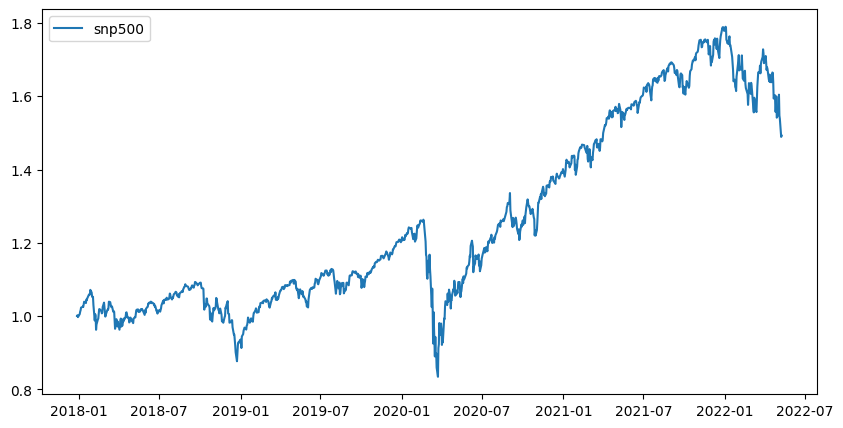

In [4]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')
ax.legend()

static compare alpha

In [2]:
def plot_stat(var, l, legends, ax = None):



    var_agg = [[] for i in range(len(l))]
    var_agg_std = [[] for i in range(len(l))]


    for i in range(len(l)):

        for cnt, alpha in enumerate(l[i]['alphas']):
            var_agg[i].append(np.mean(np.array(l[i][var][cnt])))
            var_agg_std[i].append(np.std(np.array(l[i][var][cnt])))
        var_agg[i] = np.array(var_agg[i])
        var_agg_std[i] = np.array(var_agg_std[i])



    clrs = sns.color_palette("husl", 10)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize = (10,5))
    for i in range(len(l)):
        ax.plot(l[i]['alphas'], var_agg[i], label = legends[i])


    ax.set_title(var)
    ax.set_xlabel(r"$\alpha$")
    #ax.legend(bbox_to_anchor = (1,1))

    return var_agg, var_agg_std


In [3]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t(X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def _T(u,nu):

    return np.array([chi2.ppf(u, df = nu[i])/nu[i] for i in range(len(nu))])


def integrand(u,nu,i,j):
    T_vec = _T(u,nu)


    A = 1/np.sqrt(T_vec)
    return A[i]*A[j]


integrand = np.vectorize(integrand,excluded = [1,2,3])


def C_group(d, nu,m):
    
    combination_calculated = defaultdict(lambda: None)
    D = np.zeros(shape = (d,d))

    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.quad(integrand, 0, 1 ,args = (nu,i,j))[0]
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T



def integrand2(u,nu,i,j):

    T_vec = _T(u,nu)
    e_val = nu/(nu-2)


    A = 1/T_vec
    return (A[i]-e_val[i])*(A[j]-e_val[j])



integrand2 = np.vectorize(integrand2,excluded = [1,2,3])


def C_skew(d, nu,m):
    
    combination_calculated = defaultdict(lambda: None)
    D = np.zeros(shape = (d,d))

    for i in range(D.shape[0]):
        for j in range(i, D.shape[0]):
            combintaion = ''.join(sorted(str(m[i])+str(m[j])))
            if combination_calculated[combintaion] is None:
                D[i,j] =  integrate.quad(integrand2, 0, 1 ,args = (nu,i,j))[0]
                combination_calculated[combintaion] = D[i,j]
            else:
                D[i,j] = combination_calculated[combintaion]

    return np.triu(D,0) + np.triu(D,1).T


def integrand3(u,nu,i,j, gamma):

    T_vec = _T(u,nu)
    e_val = nu/(nu-2)


    A = 1/T_vec
    A2 = 1/np.sqrt(T_vec)
    return A[i]*gamma[i]*A2[j]-e_val[i]*gamma[i]*A2[j]



integrand3 = np.vectorize(integrand3,excluded = [1,2,3,4])


def C_cov(d, nu,m, gamma):
    
    combination_calculated = defaultdict(lambda: None)
    D = np.zeros(shape = (d,d))

    for i in range(D.shape[0]):
        for j in range(D.shape[0]):

            D[i,j] =  integrate.quad(integrand3, 0, 1 ,args = (nu,i,j,gamma))[0]


    return D


def extract_info(in_dict,lik_type,w_fix, alphas = None, calc_lik = False):


    if alphas is None:
        alphas = in_dict['alphas']
    price = in_dict['price']
    X = in_dict['X']
    groups = in_dict['groups']

    sharpes_s = {i: [] for i in range(len(alphas))}
    sharpes_m = {i: [] for i in range(len(alphas))}
    ebics = {i: [] for i in range(len(alphas))}
    mdds_s = {i: [] for i in range(len(alphas))}
    mdds_m = {i: [] for i in range(len(alphas))}
    thetas= {i: [] for i in range(len(alphas))}
    Ss= {i: [] for i in range(len(alphas))}
    Cs= {i: [] for i in range(len(alphas))}
    gammas = {i: [] for i in range(len(alphas))}
    nus = {i: [] for i in range(len(alphas))}
    fro_norms = {i: [] for i in range(len(alphas))}
    ws_s = {i: [] for i in range(len(alphas))}
    ws_m = {i: [] for i in range(len(alphas))}
    mus = {i: [] for i in range(len(alphas))}
    mus_s = {i: [] for i in range(len(alphas))}
    mus_m = {i: [] for i in range(len(alphas))}
    vars_s = {i: [] for i in range(len(alphas))}
    vars_m = {i: [] for i in range(len(alphas))}
    rs_s = {i: [] for i in range(len(alphas))}
    rs_m = {i: [] for i in range(len(alphas))}
    omegas_s = {i: [] for i in range(len(alphas))}
    omegas_m = {i: [] for i in range(len(alphas))}
    port_price_s = {i: [] for i in range(len(alphas))}
    port_price_m = {i: [] for i in range(len(alphas))}
    sigmas_s = {i: [] for i in range(len(alphas))}
    sigmas_m = {i: [] for i in range(len(alphas))}
    time_forecast = {i: [] for i in range(len(alphas))}
    likelihoods = {i: [] for i in range(len(alphas))}
    future_likelihoods = {i: [] for i in range(len(alphas))}
    AIC = {i: [] for i in range(len(alphas))}
    future_AIC = {i: [] for i in range(len(alphas))}
    BIC = {i: [] for i in range(len(alphas))}
    future_BIC = {i: [] for i in range(len(alphas))}
    nr_params = {i: [] for i in range(len(alphas))}
    div_ratio_s = {i: [] for i in range(len(alphas))}
    div_ratio_m = {i: [] for i in range(len(alphas))}

    time_portfolio = {i: [] for i in range(len(alphas))}

    pbar = tqdm.tqdm(total = len(in_dict['time_index'])*len(alphas))
    for alpha_cnt, alpha in enumerate(alphas):
        for time_cnt, i in enumerate(in_dict['time_index']): 
            pbar.set_description(f"i {i}, alpha {alpha}")

            # get precision/covariance
            thetas = in_dict['thetas'][alpha_cnt][time_cnt].copy()
            if len(thetas.shape)==2:
                thetas = np.expand_dims(in_dict['thetas'][0][0],0)

            theta = thetas[-1].copy()
            precision_matrix = in_dict['thetas'][alpha_cnt][time_cnt][-1]
            precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
            S = in_dict['Ss'][alpha_cnt][time_cnt]
            nu = in_dict['nus'][alpha_cnt][time_cnt]
            gamma = in_dict['gammas'][alpha_cnt][time_cnt]


            # Update precision matrix 
            precision_matrix = np.linalg.inv(S) 

            # mu = in_dict['mus'][alpha_cnt][time_cnt]
            mu = np.median(X[i-500:i], axis = 0)

            # portfolio weights sharpe
            w_s, mu_s, var_s = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'sharpe',w_fix = w_fix)
            portfolio_s = np.dot(np.array(price.iloc[i:i + 20]),w_s)
            time_portfolio[alpha_cnt].append(price.index[i:i + 20])
            port_price_s[alpha_cnt].append(portfolio_s)
            log_returns_s = np.array(100*np.log(1+pd.DataFrame(portfolio_s).pct_change()).dropna())
            r_s = (portfolio_s[-1]-portfolio_s[0])/portfolio_s[0]
            sigma_s = np.std(log_returns_s)
            sharpe_s = pm.sharpe(r_s,sigma_s)
            sharpes_s[alpha_cnt].append(sharpe_s)
            mdds_s[alpha_cnt].append(pm.max_drawdown(portfolio_s))
            omegas_s[alpha_cnt].append(pm.omega(np.squeeze(log_returns_s)))
            ws_s[alpha_cnt].append(w_s)
            mus_s[alpha_cnt].append(mu_s)
            vars_s[alpha_cnt].append(var_s)
            rs_s[alpha_cnt].append(r_s)
            sigmas_s[alpha_cnt].append(sigma_s)
            div_ratio_s[alpha_cnt].append(pm.div_ratio(w_s, S))

            # portfolio weights minimum variance
            w_m, mu_m, var_m = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'gmv',w_fix = w_fix)

            portfolio_m = np.dot(price.iloc[i:i + 20],w_m)
            port_price_m[alpha_cnt].append(portfolio_m)
            log_returns_m = np.array(100*np.log(1+pd.DataFrame(portfolio_m).pct_change()).dropna())
            r_m = (portfolio_m[-1]-portfolio_m[0])/portfolio_m[0]
            sigma_m = np.std(log_returns_m)
            sharpe_m = pm.sharpe(r_m,sigma_m)
            sharpes_m[alpha_cnt].append(sharpe_m)
            mdds_m[alpha_cnt].append(pm.max_drawdown(portfolio_m))
            omegas_m[alpha_cnt].append(pm.omega(np.squeeze(log_returns_m)))
            ws_m[alpha_cnt].append(w_m)
            mus_m[alpha_cnt].append(mu_m)
            vars_m[alpha_cnt].append(var_m)
            rs_m[alpha_cnt].append(r_m)
            sigmas_m[alpha_cnt].append(sigma_m)
            div_ratio_m[alpha_cnt].append(pm.div_ratio(w_m, S))


            if calc_lik:
                likelihoods[alpha_cnt].append(log_lik(np.zeros(theta.shape[1]) ,
                                                    np.linalg.inv(theta), 
                                                    np.array(X[i-500:i]-mu), 
                                                    liktype = lik_type, 
                                                    nu = nu,
                                                    prec = theta,
                                                    gamma = gamma,
                                                    n = 10))
                
                
                future_likelihoods[alpha_cnt].append(log_lik(np.zeros(theta.shape[1]) ,
                                                    np.linalg.inv(theta), 
                                                    np.array(X[i:i+20]-mu), 
                                                    liktype = lik_type, 
                                                    nu = nu,
                                                    prec = theta,
                                                    gamma = gamma,
                                                    n = 10))



                theta[np.abs(theta)<1e-2] = 0
                if lik_type == 't':
                    nr_params[alpha_cnt].append(np.sum(theta[np.triu_indices(theta.shape[0],1)] != 0) + 1.0)
                elif lik_type == 'group-t':
                    nr_params[alpha_cnt].append(np.sum(theta[np.triu_indices(theta.shape[0],1)] != 0) + float(len(nu)))
                elif lik_type == 'skew-group-t':
                    nr_params[alpha_cnt].append(np.sum(theta[np.triu_indices(theta.shape[0],1)] != 0) + float(len(nu)) + float(theta.shape[0]))
                else:
                    nr_params[alpha_cnt].append(np.sum(theta[np.triu_indices(theta.shape[0],1)] != 0))
                # print(nr_params)
                AIC[alpha_cnt].append(2*(nr_params[alpha_cnt][-1] - likelihoods[alpha_cnt][-1]))
                future_AIC[alpha_cnt].append(2*(nr_params[alpha_cnt][-1] - future_likelihoods[alpha_cnt][-1]))
                BIC[alpha_cnt].append((nr_params[alpha_cnt][-1]*np.log(500) - 2*likelihoods[alpha_cnt][-1]))
                future_BIC[alpha_cnt].append((nr_params[alpha_cnt][-1]*np.log(20) - 2*future_likelihoods[alpha_cnt][-1]))
            
            else:
                likelihoods = in_dict['likelihoods']
                future_likelihoods = in_dict['future_likelihoods']
                nr_params = in_dict['nr_params']
                AIC = in_dict['AIC']
                future_AIC = in_dict['future_AIC']
                BIC = in_dict['BIC']
                future_BIC = in_dict['future_BIC']



                

            # add stuff independent of portfolio
            time_forecast[alpha_cnt].append(price.index[i+1:i + 20])
            pbar.update()
            # ebics[alpha_cnt].append(ebic(np.zeros(S.shape[0]),S, precision_matrix, log_returns_scaled, liktype=lik_type, nu = dg_opt.nu, beta = 0.5))

            # Guess next theta
            # if lik_type in ('groupt-t', 'skew-group-t', 't', 'gaussian'):
            #     theta_init = dg_opt.theta.copy()

    pbar.close()
    out_dict = {'time_forecast':time_forecast,'likelihoods':likelihoods, 'alphas':alphas, 'future_likelihoods':future_likelihoods, 'nr_params':nr_params,
                'AIC':AIC, 'future_AIC':future_AIC, 'BIC':BIC, 'future_BIC':future_BIC, 'time_portfolio':time_portfolio,
                'sharpes_s':sharpes_s,  'mdds_s':mdds_s,   'ws_s':ws_s, 'mus_s':mus_s, 'vars_s':vars_s, 'rs_s':rs_s, 
                'omegas_s':omegas_s,'port_price_s':port_price_s, 'sigmas_s':sigmas_s, 'div_ratio_s':div_ratio_s,
                'sharpes_m':sharpes_m,  'mdds_m':mdds_m,   'ws_m':ws_m, 'mus_m':mus_m, 'vars_m':vars_m, 'rs_m':rs_m, 
                'omegas_m':omegas_m,'port_price_m':port_price_m, 'sigmas_m':sigmas_m, 'div_ratio_m':div_ratio_m}
    
    return out_dict

def extract_info_dynamic(in_dict,lik_type,w_fix, calc_lik):


    alphas = in_dict['alphas']
    time_index = in_dict['time_index']
    price = in_dict['price']
    X = in_dict['X']

    sharpes_s = {i: [] for i in range(len(alphas))}
    sharpes_m = {i: [] for i in range(len(alphas))}
    ebics = {i: [] for i in range(len(alphas))}
    mdds_s = {i: [] for i in range(len(alphas))}
    mdds_m = {i: [] for i in range(len(alphas))}
    thetas= {i: [] for i in range(len(alphas))}
    Ss= {i: [] for i in range(len(alphas))}
    Cs= {i: [] for i in range(len(alphas))}
    gammas = {i: [] for i in range(len(alphas))}
    nus = {i: [] for i in range(len(alphas))}
    fro_norms = {i: [] for i in range(len(alphas))}
    ws_s = {i: [] for i in range(len(alphas))}
    ws_m = {i: [] for i in range(len(alphas))}
    mus = {i: [] for i in range(len(alphas))}
    mus_s = {i: [] for i in range(len(alphas))}
    mus_m = {i: [] for i in range(len(alphas))}
    vars_s = {i: [] for i in range(len(alphas))}
    vars_m = {i: [] for i in range(len(alphas))}
    rs_s = {i: [] for i in range(len(alphas))}
    rs_m = {i: [] for i in range(len(alphas))}
    omegas_s = {i: [] for i in range(len(alphas))}
    omegas_m = {i: [] for i in range(len(alphas))}
    port_price_s = {i: [] for i in range(len(alphas))}
    port_price_m = {i: [] for i in range(len(alphas))}
    sigmas_s = {i: [] for i in range(len(alphas))}
    sigmas_m = {i: [] for i in range(len(alphas))}
    time_forecast = {i: [] for i in range(len(alphas))}

    likelihoods = {i: [] for i in range(len(alphas))}
    future_likelihoods = {i: [] for i in range(len(alphas))}
    AIC = {i: [] for i in range(len(alphas))}
    future_AIC = {i: [] for i in range(len(alphas))}
    BIC = {i: [] for i in range(len(alphas))}
    future_BIC = {i: [] for i in range(len(alphas))}
    nr_params = {i: [] for i in range(len(alphas))}

    pbar = tqdm.tqdm(total = len(time_index)*len(alphas), position=1)

    for alpha_cnt, alpha in enumerate(alphas):

        for time_cnt, i in enumerate(in_dict['time_index']): 
            pbar.set_description(f"i {i}, alpha {alpha}")

            # get precision/covariance
            thetas = in_dict['thetas'][alpha_cnt][time_cnt].copy()
                

            precision_matrix = in_dict['thetas'][alpha_cnt][time_cnt][-1]
            precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
            S = in_dict['Ss'][alpha_cnt][time_cnt]
            nu = in_dict['nus'][alpha_cnt][time_cnt]
            gamma = in_dict['gammas'][alpha_cnt][time_cnt]
            precision_matrix = np.linalg.inv(S) 

            # mu = in_dict['mus'][alpha_cnt][time_cnt]
            mu = np.median(X[i-500:i], axis = 0)

            # portfolio weights sharpe
            w_s, mu_s, var_s = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'sharpe',w_fix = w_fix)
            portfolio_s = np.dot(np.array(price.iloc[i:i + 20]),w_s)
            port_price_s[alpha_cnt].append(portfolio_s)
            log_returns_s = np.array(100*np.log(1+pd.DataFrame(portfolio_s).pct_change()).dropna())
            r_s = (portfolio_s[-1]-portfolio_s[0])/portfolio_s[0]
            sigma_s = np.std(log_returns_s)
            sharpe_s = pm.sharpe(r_s,sigma_s)
            sharpes_s[alpha_cnt].append(sharpe_s)
            mdds_s[alpha_cnt].append(pm.max_drawdown(portfolio_s))
            omegas_s[alpha_cnt].append(pm.omega(np.squeeze(log_returns_s)))
            ws_s[alpha_cnt].append(w_s)
            mus_s[alpha_cnt].append(mu_s)
            vars_s[alpha_cnt].append(var_s)
            rs_s[alpha_cnt].append(r_s)
            sigmas_s[alpha_cnt].append(sigma_s)

            # portfolio weights minimum variance
            w_m, mu_m, var_m = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'gmv',w_fix = w_fix)

            portfolio_m = np.dot(price.iloc[i:i + 20],w_m)
            port_price_m[alpha_cnt].append(portfolio_m)
            log_returns_m = np.array(100*np.log(1+pd.DataFrame(portfolio_m).pct_change()).dropna())
            r_m = (portfolio_m[-1]-portfolio_m[0])/portfolio_m[0]
            sigma_m = np.std(log_returns_m)
            sharpe_m = pm.sharpe(r_m,sigma_m)
            sharpes_m[alpha_cnt].append(sharpe_m)
            mdds_m[alpha_cnt].append(pm.max_drawdown(portfolio_m))
            omegas_m[alpha_cnt].append(pm.omega(np.squeeze(log_returns_m)))
            ws_m[alpha_cnt].append(w_m)
            mus_m[alpha_cnt].append(mu_m)
            vars_m[alpha_cnt].append(var_m)
            rs_m[alpha_cnt].append(r_m)
            sigmas_m[alpha_cnt].append(sigma_m)
            

            if calc_lik:
                lik_tmp = []
                w = in_dict['obs_per_graph']
                for j in range(len(thetas)):
                    X_tmp = X[j*w:(j+1)*w]
                    lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X_tmp-mu, liktype = lik_type, nu = nu[j], gamma = gamma[j]))

                likelihoods[alpha_cnt].append(np.sum(lik_tmp))

                future_likelihoods[alpha_cnt].append(log_lik(np.zeros(thetas[-1].shape[1]) ,
                                                    np.linalg.inv(thetas[-1]), 
                                                    np.array(X[i:i+20]-np.mean(X[i:i+20],axis = 0)), 
                                                    liktype = lik_type, 
                                                    nu = nu[-1],
                                                    prec = thetas[-1],
                                                    gamma = gamma[-1],
                                                    n = 10))



                nr_params_tmp = []
                for iii in range(len(thetas)):
                    theta_t = thetas[iii].copy()
                    theta_t[np.abs(theta_t)<1e-2] = 0
                    if lik_type == 't':
                        nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
                    elif lik_type == 'group-t':
                        nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]))
                    elif lik_type == 'skew-group-t':
                        nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
                    else:
                        nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

                nr_params[alpha_cnt].append(nr_params_tmp)

                AIC[alpha_cnt].append(2*np.sum(nr_params_tmp) -2*np.sum(lik_tmp) )
                future_AIC[alpha_cnt].append(2*(nr_params_tmp[-1] - future_likelihoods[alpha_cnt][-1]))
                BIC[alpha_cnt].append(np.sum(nr_params_tmp)*np.log(500) -2*np.sum(lik_tmp) )
                future_BIC[alpha_cnt].append(nr_params_tmp[-1]*np.log(20) - 2*future_likelihoods[alpha_cnt][-1])
            else:
                likelihoods = in_dict['likelihoods']
                future_likelihoods = in_dict['future_likelihoods']
                nr_params = in_dict['nr_params']
                AIC = in_dict['AIC']
                future_AIC = in_dict['future_AIC']
                BIC = in_dict['BIC']
                future_BIC = in_dict['future_BIC']

            

            # add stuff independent of portfolio
            time_forecast[alpha_cnt].append(price.index[i:i + 20])
            # ebics[alpha_cnt].append(ebic(np.zeros(S.shape[0]),S, precision_matrix, log_returns_scaled, liktype=lik_type, nu = dg_opt.nu, beta = 0.5))

            # Guess next theta
            # if lik_type in ('groupt-t', 'skew-group-t', 't', 'gaussian'):
            #     theta_init = dg_opt.theta.copy()

            pbar.update()

    pbar.close()
    out_dict = {'time_forecast':time_forecast,'likelihoods':likelihoods, 'alphas':alphas, 
                'future_likelihoods':future_likelihoods, 'nr_params':nr_params,
                'AIC':AIC, 'future_AIC':future_AIC, 'BIC':BIC, 'future_BIC':future_BIC,
                'sharpes_s':sharpes_s,  'mdds_s':mdds_s,   'ws_s':ws_s, 'mus_s':mus_s, 'vars_s':vars_s, 'rs_s':rs_s, 
                'omegas_s':omegas_s,'port_price_s':port_price_s, 'sigmas_s':sigmas_s,
                'sharpes_m':sharpes_m,  'mdds_m':mdds_m,   'ws_m':ws_m, 'mus_m':mus_m, 'vars_m':vars_m, 'rs_m':rs_m, 
                'omegas_m':omegas_m,'port_price_m':port_price_m, 'sigmas_m':sigmas_m,}
    
    return out_dict

In [4]:
with open(f'../data/case_study_etf/covariance_nr_quad_10_etf_static_l_20.pkl', 'rb') as handle:
    cov_port = pickle.load(handle)
cov_port_info = extract_info(cov_port,'gaussian', False, calc_lik=False)
with open(f'../data/case_study_etf/LedoitWolf_nr_quad_10_etf_static_l_20.pkl', 'rb') as handle:
    lw_port = pickle.load(handle)
lw_port_info = extract_info(lw_port,'gaussian', False, calc_lik=False)

i 500, alpha 0.001:   0%|          | 0/432 [00:00<?, ?it/s]

i 1360, alpha 0.001:  10%|▉         | 43/432 [00:04<00:36, 10.53it/s]c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
i 1560, alpha 0.4: 100%|██████████| 432/432 [00:42<00:00, 10.17it/s]  


In [5]:
with open(f'../data/case_study_etf/gaussian_nr_quad_5_etf_static_l_20.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
static_gaussian_port_info = extract_info(static_gaussian_port,'gaussian', True, calc_lik=True)

with open(f'../data/case_study_etf/t_nr_quad_5_etf_static_l_20.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)
static_t_port_info = extract_info(static_t_port,'t', True, calc_lik=True)

with open(f'../data/case_study_etf/static_gt_port_info.pkl', 'rb') as handle:
    static_gt_port_info = pickle.load(handle)
# static_gt_port_info = extract_info(static_gt_port,'group-t', True, calc_lik=True)


with open(f'../data/case_study_etf/static_sgt_port_info.pkl', 'rb') as handle:
    static_sgt_port_info = pickle.load(handle)
# static_sgt_port_info = extract_info(static_sgt_port,'skew-group-t', True, calc_lik=True)



i 1560, alpha 0.4: 100%|██████████| 486/486 [00:45<00:00, 10.68it/s]  


In [165]:
# with open(f'../data/case_study_etf/static_sgt_port_info.pkl', 'wb') as handle:
#     pickle.dump(static_sgt_port_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'../data/case_study_etf/static_gt_port_info.pkl', 'wb') as handle:
#     pickle.dump(static_gt_port_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

load temporal

In [6]:
with open(f'../data/case_study_etf/d_t_50_gr.pkl', 'rb') as handle:
    d_t_50_gr = pickle.load(handle)
with open(f'../data/case_study_etf/d_t_50_ridge.pkl', 'rb') as handle:
    d_t_50_ridge = pickle.load(handle)
with open(f'../data/case_study_etf/d_t_50_ew.pkl', 'rb') as handle:
    d_t_50_ew = pickle.load(handle)
with open(f'../data/case_study_etf/d_t_50_bwr.pkl', 'rb') as handle:
    d_t_50_bwr = pickle.load(handle)
with open(f'../data/case_study_etf/d_t_50_pn.pkl', 'rb') as handle:
    d_t_50_pn = pickle.load(handle)

with open(f'../data/case_study_etf/d_gaussian_50_gr.pkl', 'rb') as handle:
    d_gaussian_50_gr = pickle.load(handle)
with open(f'../data/case_study_etf/d_gaussian_50_ridge.pkl', 'rb') as handle:
    d_gaussian_50_ridge = pickle.load(handle)
with open(f'../data/case_study_etf/d_gaussian_50_ew.pkl', 'rb') as handle:
    d_gaussian_50_ew = pickle.load(handle)
with open(f'../data/case_study_etf/d_gaussian_50_bwr.pkl', 'rb') as handle:
    d_gaussian_50_bwr = pickle.load(handle)
with open(f'../data/case_study_etf/d_gaussian_50_pn.pkl', 'rb') as handle:
    d_gaussian_50_pn = pickle.load(handle)


with open(f'../data/case_study_etf/d_gt_50_ew.pkl', 'rb') as handle:
    d_gt_50_ew = pickle.load(handle)

with open(f'../data/case_study_etf/d_sgt_50_ew.pkl', 'rb') as handle:
    d_sgt_50_ew = pickle.load(handle)


In [12]:
# with open(f'../data/case_study_etf/static_sgt_port_info.pkl', 'wb') as handle:
#     pickle.dump(static_sgt_port_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of parameters

In [73]:
np.mean(np.array(d_t_50_ew['0.4']['nr_params'][0]), axis= 0)[-1]

55.127272727272725

In [10]:
static_sgt_port_info.keys()

dict_keys(['time_forecast', 'likelihoods', 'alphas', 'future_likelihoods', 'nr_params', 'AIC', 'future_AIC', 'BIC', 'future_BIC', 'sharpes_s', 'mdds_s', 'ws_s', 'mus_s', 'vars_s', 'rs_s', 'omegas_s', 'port_price_s', 'sigmas_s', 'div_ratio_s', 'sharpes_m', 'mdds_m', 'ws_m', 'mus_m', 'vars_m', 'rs_m', 'omegas_m', 'port_price_m', 'sigmas_m', 'div_ratio_m'])

In [27]:
np.array(static_sgt_port_info['nr_params'][i]) - 11 -11

array([50., 50., 49., 49., 47., 49., 50., 53., 54., 50., 50., 51., 52.,
       50., 51., 51., 52., 54., 54., 52., 52., 51., 53., 55., 55., 53.,
       54., 53., 53., 53., 50., 50., 47., 45., 48., 47., 51., 51., 53.,
       52., 54., 54., 55., 54., 52., 52., 53., 53., 53., 53., 53., 55.,
       53., 52.])

('Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t')

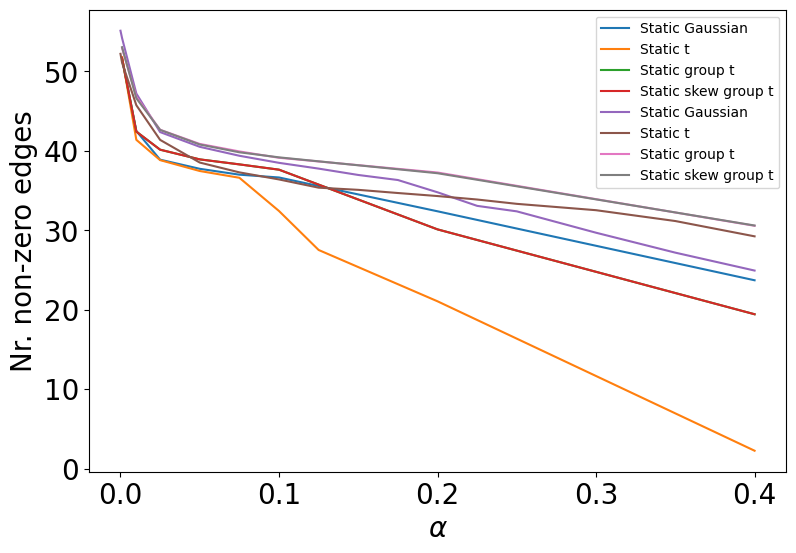

In [30]:
gussian_nr_params = []
t_nr_params = []
gt_nr_params = []
sgt_nr_params = []

dg_nr_params = []
dt_nr_params = []
dgt_nr_params = []
dsgt_nr_params = []



#d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']

for i in range(len(static_gaussian_port_info['nr_params'].keys())):
    gussian_nr_params.append(np.mean(np.array(static_gaussian_port_info['nr_params'][i])))
for i in range(len(static_t_port_info['nr_params'].keys())):
    t_nr_params.append(np.mean(np.array(static_t_port_info['nr_params'][i]) - 1))
for i in range(len(static_gt_port_info['nr_params'].keys())):
    gt_nr_params.append(np.mean(np.array(static_gt_port_info['nr_params'][i]) - 11 ))
for i in range(len(static_sgt_port_info['nr_params'].keys())):
    sgt_nr_params.append(np.mean(np.array(static_sgt_port_info['nr_params'][i]) - 11 - 11 ))


for i in range(len(d_t_50_ew['0.4']['alphas'])):
    dt_nr_params.append(np.mean(np.array(d_t_50_ew['0.4']['nr_params'][i]), axis= 0)[-1])
for i in range(len(d_gaussian_50_ew['0.4']['alphas'])):
    dg_nr_params.append(np.mean(np.array(d_gaussian_50_ew['0.4']['nr_params'][i]) - 1, axis= 0)[-1])
for i in range(len(d_gt_50_ew['0.4']['alphas'])):
    dgt_nr_params.append(np.mean(np.array(d_gt_50_ew['0.4']['nr_params'][i]) - 11 , axis= 0)[-1])
for i in range(len(d_sgt_50_ew['0.4']['alphas'])):
    dsgt_nr_params.append(np.mean(np.array(d_sgt_50_ew['0.4']['nr_params'][i]) - 11- 11 , axis= 0)[-1])

fig, ax = plt.subplots(1,1, figsize = (9,6))
ax.plot(static_gaussian_port_info['alphas'], gussian_nr_params, label = 'Static Gaussian')
ax.plot(static_t_port_info['alphas'], t_nr_params, label = 'Static t')
ax.plot(static_gt_port_info['alphas'], gt_nr_params, label = 'Static group t')
ax.plot(static_sgt_port_info['alphas'], sgt_nr_params, label = 'Static skew group t')
ax.plot(d_t_50_ew['0.4']['alphas'], dt_nr_params, label = 'Static Gaussian')
ax.plot(d_gaussian_50_ew['0.4']['alphas'], dg_nr_params, label = 'Static t')
ax.plot(d_gt_50_ew['0.4']['alphas'], dgt_nr_params, label = 'Static group t')
ax.plot(d_sgt_50_ew['0.4']['alphas'], dsgt_nr_params, label = 'Static skew group t')
ax.set_title("")
ax.set_ylabel("Nr. non-zero edges", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'


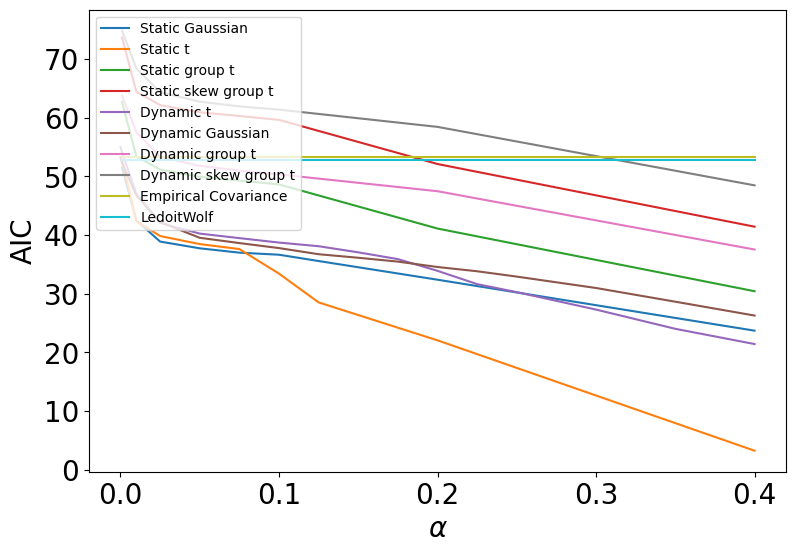

In [31]:
fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('nr_params', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4'], cov_port_info, lw_port_info], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t', 'Empirical Covariance', 'LedoitWolf'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')

Portfolio performance

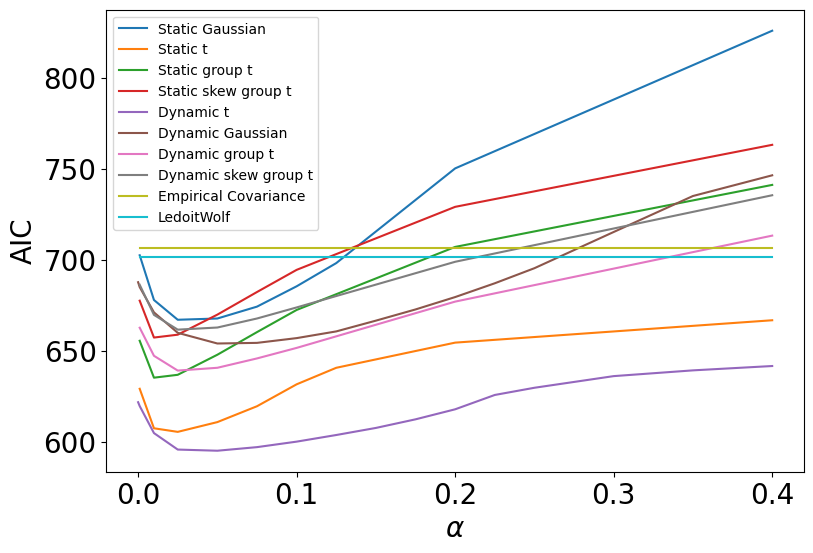

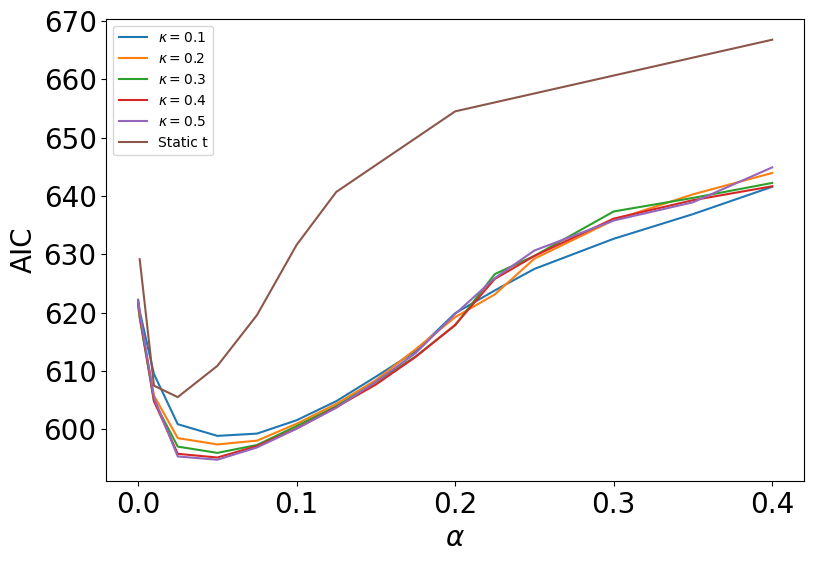

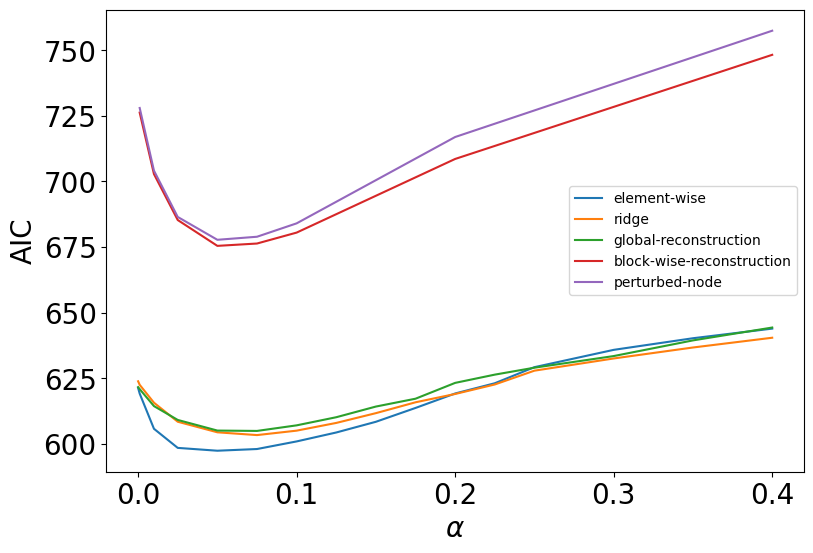

In [12]:
fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4'], cov_port_info, lw_port_info], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t', 'Empirical Covariance', 'LedoitWolf'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')

fig, ax = plt.subplots(1,1, figsize = (9,6))
_,_ = plot_stat('future_AIC', [val for val in d_t_50_ew.values()] + [static_t_port_info], 
                [r'$\kappa=0.1$', r'$\kappa=0.2$',r'$\kappa=0.3$',r'$\kappa=0.4$',r'$\kappa=0.5$'] + ['Static t'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()


fig, ax = plt.subplots(1,1, figsize = (9,6))
_,_ = plot_stat('future_AIC', [val for val in [d_t_50_ew['0.2'], d_t_50_ridge['0.2'], d_t_50_gr['0.2'], d_t_50_bwr['0.5'], d_t_50_pn['0.5']]], 
                ['element-wise', 'ridge', 'global-reconstruction', 'block-wise-reconstruction', 'perturbed-node'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()


Plot changes

In [93]:
d_t_50_ew['0.4'].keys()

dict_keys(['time_forecast', 'likelihoods', 'alphas', 'future_likelihoods', 'nr_params', 'AIC', 'future_AIC', 'BIC', 'future_BIC', 'sharpes_s', 'mdds_s', 'ws_s', 'mus_s', 'vars_s', 'rs_s', 'omegas_s', 'port_price_s', 'sigmas_s', 'sharpes_m', 'mdds_m', 'ws_m', 'mus_m', 'vars_m', 'rs_m', 'omegas_m', 'port_price_m', 'sigmas_m'])

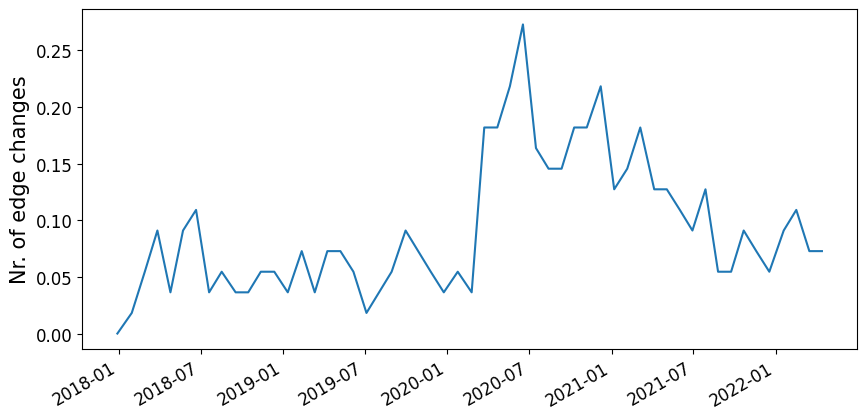

In [130]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.5_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port1 = pickle.load(handle)

def nr_diff_elements(x,y,tol = 1e-1):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A)>1e-1)

nr_diff_elements_arr = np.zeros((len(d_port1['thetas']), len(d_port1['thetas'][0])))

for i in range(nr_diff_elements_arr.shape[0]):
    for j in range(nr_diff_elements_arr.shape[1]):

        nr_diff_elements_arr[i,j] = np.sum([nr_diff_elements(d_port1['thetas'][i][j][k+1],d_port1['thetas'][i][j][k]) for k in range(len(d_port1['thetas'][i][j])-1)])

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(d_port1['time_change'], nr_diff_elements_arr[3]/(11*10/2))
ax.set_ylabel("Ratio of edge changes", fontdict = {'fontsize':15})
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
#ax.xaxis.set_tick_params(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=12)

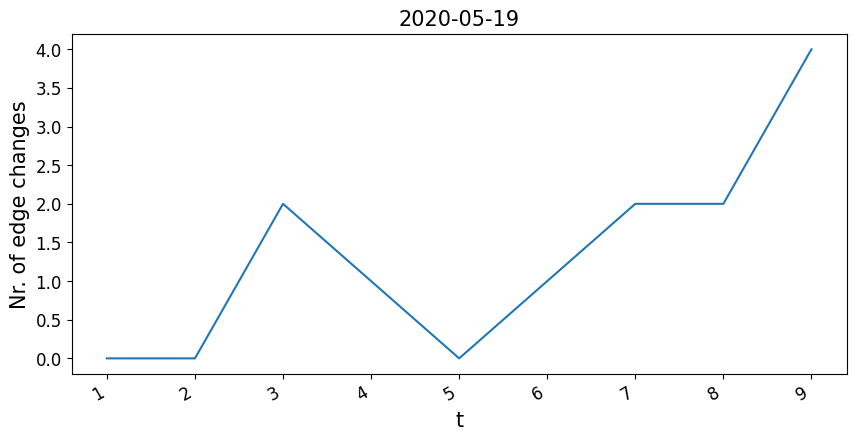

In [133]:

i = 3
j = 30
nr_diff_elements_arr = np.array([nr_diff_elements(d_port1['thetas'][i][j][k+1],d_port1['thetas'][i][j][k]) for k in range(len(d_port1['thetas'][i][j])-1)])

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(np.array(range(len(nr_diff_elements_arr)))+1, nr_diff_elements_arr)
ax.set_ylabel("Nr. of edge changes", fontdict = {'fontsize':15})
ax.set_xlabel("t", fontdict = {'fontsize':15})
ax.set_title(datetime.date(d_port1['time_change'][j].year, d_port1['time_change'][j].month, d_port1['time_change'][j].day), fontdict = {'fontsize':15})
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
#ax.xaxis.set_tick_params(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=12)

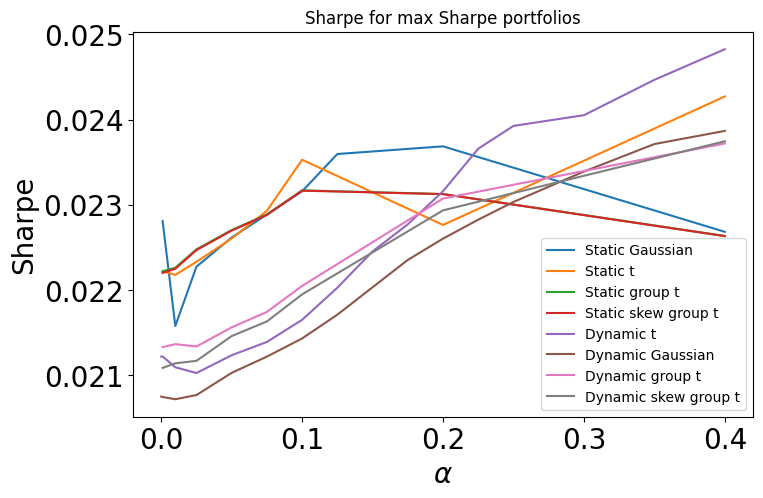

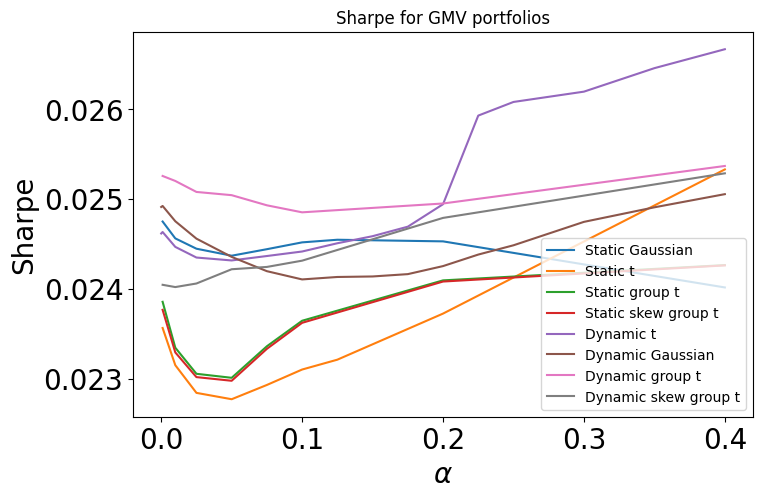

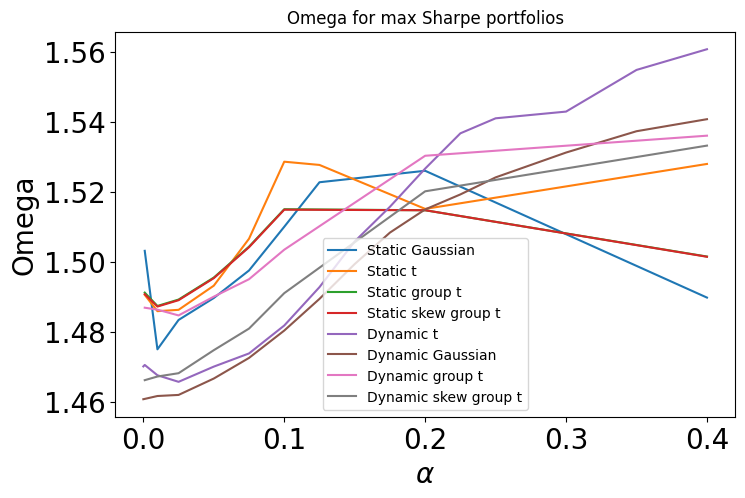

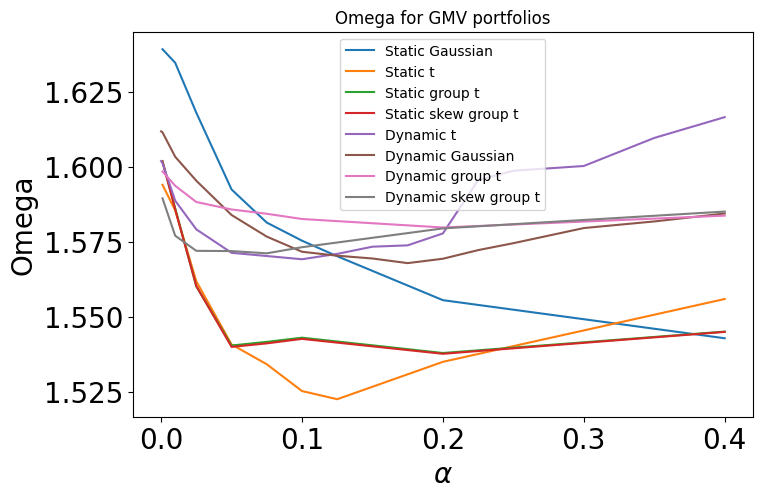

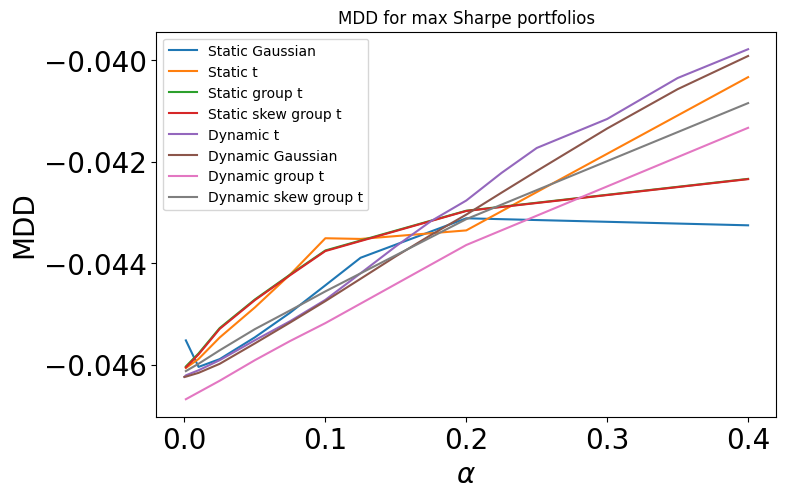

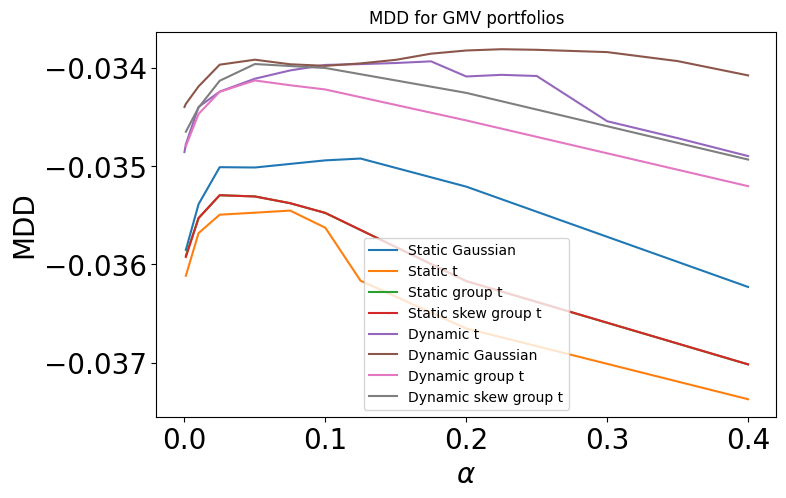

In [236]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('sharpes_s', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'], ax = ax)
ax.set_title("Sharpe for max Sharpe portfolios")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('sharpes_m', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'], ax = ax)
ax.set_title("Sharpe for GMV portfolios")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('omegas_s', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'], ax = ax)
ax.set_title("Omega for max Sharpe portfolios")
ax.set_ylabel("Omega", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('omegas_m', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'], ax = ax)
ax.set_title("Omega for GMV portfolios")
ax.set_ylabel("Omega", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()



fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('mdds_s', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'], ax = ax)
ax.set_title("MDD for max Sharpe portfolios")
ax.set_ylabel("MDD", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('mdds_m', [static_gaussian_port_info, static_t_port_info, static_gt_port_info, static_sgt_port_info , d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4'], d_sgt_50_ew['0.4']], 
                                 ['Static Gaussian', 'Static t', 'Static group t', 'Static skew group t', 'Dynamic t', 'Dynamic Gaussian', 'Dynamic group t', 'Dynamic skew group t'], ax = ax)
ax.set_title("MDD for GMV portfolios")
ax.set_ylabel("MDD", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

In [157]:
len(d_gt_50_ew['0.4']['port_price_s'][3])

55

In [209]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[500:]/data['Adj Close'].iloc[500]


[*********************100%***********************]  1 of 1 completed


In [203]:
data.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23',
               '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27',
               '2023-01-30', '2023-01-31'],
              dtype='datetime64[ns]', name='Date', length=1782, freq=None)

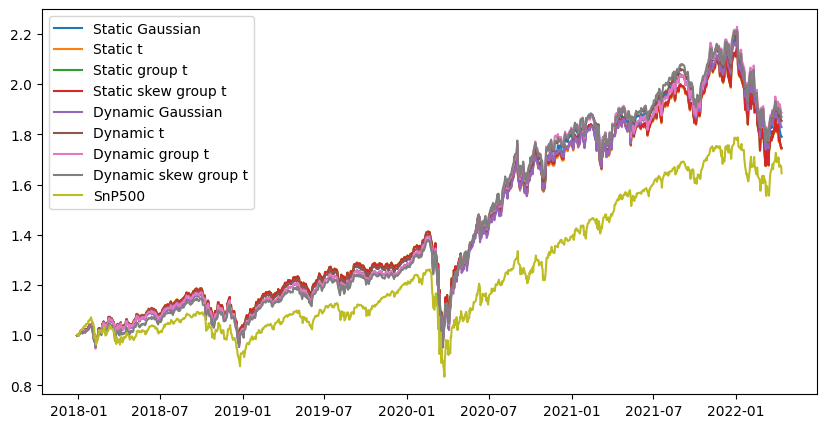

In [241]:
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


#static_gaussian_port_info, static_t_port_info, static_gt_port_info, d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4']


s_n_price = cum_prod_port(static_gaussian_port_info['port_price_s'][2])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
s_t_price = cum_prod_port(static_t_port_info['port_price_s'][2]) 
s_gt_price = cum_prod_port(static_gt_port_info['port_price_s'][5]) 
s_sgt_price = cum_prod_port(static_sgt_port_info['port_price_s'][5]) 
d_n_price = cum_prod_port(d_gaussian_50_ew['0.4']['port_price_s'][2])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
d_t_price = cum_prod_port(d_t_50_ew['0.4']['port_price_s'][2]) 
d_gt_price = cum_prod_port(d_gt_50_ew['0.4']['port_price_s'][5]) 
d_sgt_price = cum_prod_port(d_sgt_50_ew['0.4']['port_price_s'][2]) 


#price = price.loc[np.isin(price.index)]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(np.concatenate([dt[1:] for dt in static_gaussian_port['time_forecast'][0]]),s_n_price, label = 'Static Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in static_gaussian_port['time_forecast'][0]]),s_t_price, label = 'Static t')
ax.plot(np.concatenate([dt[1:] for dt in static_gaussian_port['time_forecast'][0]]),s_gt_price, label = 'Static group t')
ax.plot(np.concatenate([dt[1:] for dt in static_gaussian_port['time_forecast'][0]]),s_gt_price, label = 'Static skew group t')
ax.plot(np.concatenate([dt[1:] for dt in d_gaussian_50_ew['0.4']['time_forecast'][0]])[:1026],d_n_price[:1026], label = 'Dynamic Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in d_gaussian_50_ew['0.4']['time_forecast'][0]])[:1026],d_t_price[:1026], label = 'Dynamic t')
ax.plot(np.concatenate([dt[1:] for dt in d_gaussian_50_ew['0.4']['time_forecast'][0]])[:1026],d_gt_price[:1026], label = 'Dynamic group t')
ax.plot(np.concatenate([dt[1:] for dt in d_gaussian_50_ew['0.4']['time_forecast'][0]])[:1026],d_sgt_price[:1026], label = 'Dynamic skew group t')
ax.plot(static_gaussian_port['X'].index[500:1580], np.cumprod(1+price.pct_change())[:1080], label = 'SnP500')
# ax.plot(s_t_price, label = 'Static t')
ax.legend()

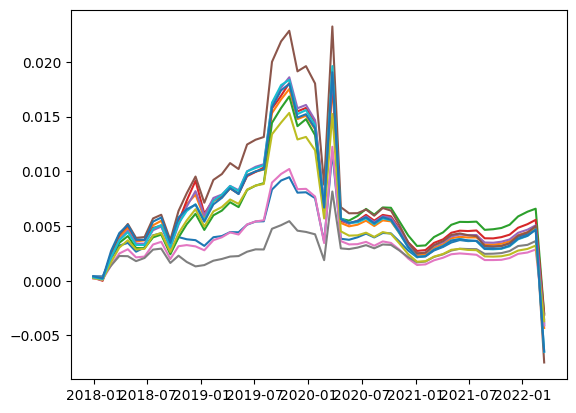

In [22]:
plt.plot(static_sgt_port['time_change'], static_sgt_port['gammas'][5])

test dynamic

In [28]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.1_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port1 = pickle.load(handle)

def nr_diff_elements(x,y,tol = 1e-1):
    A = x-y
    return np.sum(np.abs(A)>1e-1)

nr_diff_elements_arr = np.zeros((len(d_port1['thetas']), len(d_port1['thetas'][0])))

for i in range(nr_diff_elements_arr.shape[0]):
    for j in range(nr_diff_elements_arr.shape[1]):

        nr_diff_elements_arr[i,j] = np.sum([nr_diff_elements(d_port1['thetas'][i][j][k+1],d_port1['thetas'][i][j][k]) for k in range(len(d_port1['thetas'][i][j])-1)])

# [ np.sum(d_port1['thetas'][2][0][1]-d_port1['thetas'][2][0][0])

In [27]:
# d_gaussian_50_ew = dict()

# pbar = tqdm.tqdm(total = len([0.1, 0.2,0.3,0.4,0.5]))

# for k in [0.1, 0.2,0.3,0.4,0.5]:
#     with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{k}_disjoint_50_element-wise.pkl', 'rb') as handle:
#         d_port1 = pickle.load(handle)
#     d_gaussian_50_ew[str(k)] = extract_info_dynamic(d_port1,'gaussian', True)
#     pbar.update()
# pbar.close()


# d_gaussian_50_ridge = dict()

# pbar = tqdm.tqdm(total = len([0.1, 0.2,0.3,0.4,0.5]))

# for k in [0.1, 0.2,0.3,0.4,0.5]:
#     with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{k}_disjoint_50_ridge.pkl', 'rb') as handle:
#         d_port1 = pickle.load(handle)
#     d_gaussian_50_ridge[str(k)] = extract_info_dynamic(d_port1,'gaussian', True)
#     pbar.update()
# pbar.close()


# d_gaussian_50_gr = dict()

# pbar = tqdm.tqdm(total = len([0.1, 0.2,0.3,0.4,0.5]))

# for k in [0.1, 0.2,0.3,0.4,0.5]:
#     with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{k}_disjoint_50_global-reconstruction.pkl', 'rb') as handle:
#         d_port1 = pickle.load(handle)
#     d_gaussian_50_gr[str(k)] = extract_info_dynamic(d_port1,'gaussian', True)
#     pbar.update()
# pbar.close()

d_gaussian_50_bwr = dict()

for k in [0.5]:
    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{k}_disjoint_50_block-wise-reconstruction.pkl', 'rb') as handle:
        d_port1 = pickle.load(handle)
    d_gaussian_50_bwr[str(k)] = extract_info_dynamic(d_port1,'gaussian', True, True)

d_gaussian_50_pn = dict()

for k in [0.5]:
    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{k}_disjoint_50_perturbed-node.pkl', 'rb') as handle:
        d_port1 = pickle.load(handle)
    d_gaussian_50_pn[str(k)] = extract_info_dynamic(d_port1,'gaussian', True, True)



i 1580, alpha 0.001: 100%|██████████| 440/440 [00:26<00:00, 16.69it/s]


In [29]:
# with open(f'../data/case_study_etf/d_gaussian_50_gr.pkl', 'wb') as handle:
#     pickle.dump(d_gaussian_50_gr, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_gaussian_50_ridge.pkl', 'wb') as handle:
#     pickle.dump(d_gaussian_50_ridge, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_gaussian_50_ew.pkl', 'wb') as handle:
#     pickle.dump(d_gaussian_50_ew, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_gaussian_50_bwr.pkl', 'wb') as handle:
#     pickle.dump(d_gaussian_50_bwr, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_gaussian_50_pn.pkl', 'wb') as handle:
#     pickle.dump(d_gaussian_50_pn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# d_t_50_ew = dict()
# pbar = tqdm.tqdm(total = len([0.1, 0.2,0.3,0.4,0.5]))
# for k in [0.1,0.2,0.3,0.4,0.5]:
#     with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{k}_disjoint_50_element-wise.pkl', 'rb') as handle:
#         dt_port1 = pickle.load(handle)
#     d_t_50_ew[str(k)] = extract_info_dynamic(dt_port1,'t', True)
#     pbar.update()
# pbar.close()

# d_t_50_ridge = dict()
# pbar = tqdm.tqdm(total = len([0.1, 0.2,0.3,0.4,0.5]))
# for k in [0.1,0.2,0.3,0.4,0.5]:
#     with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{k}_disjoint_50_ridge.pkl', 'rb') as handle:
#         dt_port1 = pickle.load(handle)
#     d_t_50_ridge[str(k)] = extract_info_dynamic(dt_port1,'t', True)
#     pbar.update()
# pbar.close()

# d_t_50_gr = dict()
# pbar = tqdm.tqdm(total = len([0.1, 0.2,0.3,0.4,0.5]))
# for k in [0.1,0.2,0.3,0.4,0.5]:
#     with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{k}_disjoint_50_global-reconstruction.pkl', 'rb') as handle:
#         dt_port1 = pickle.load(handle)
#     d_t_50_gr[str(k)] = extract_info_dynamic(dt_port1,'t', True)
#     pbar.update()
# pbar.close()



# d_t_50_bwr = dict()

# for k in [0.5]:
#     with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{k}_disjoint_50_block-wise-reconstruction.pkl', 'rb') as handle:
#         d_port1 = pickle.load(handle)
#     d_t_50_bwr[str(k)] = extract_info_dynamic(d_port1,'t', True, True)

# d_t_50_pn = dict()

# for k in [0.5]:
#     with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{k}_disjoint_50_perturbed-node.pkl', 'rb') as handle:
#         d_port1 = pickle.load(handle)
#     d_t_50_pn[str(k)] = extract_info_dynamic(d_port1,'t', True, True)


i 1580, alpha 0.001: 100%|██████████| 440/440 [00:26<00:00, 16.48it/s]


In [34]:
# with open(f'../data/case_study_etf/d_t_50_bwr.pkl', 'wb') as handle:
#     pickle.dump(d_t_50_bwr, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_t_50_pn.pkl', 'wb') as handle:
#     pickle.dump(d_t_50_pn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
# d_gt_50_ew = dict()
# pbar = tqdm.tqdm(total = len([0.4]))
# for k in [0.4]:
#     with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_k_{k}_disjoint_50_element-wise.pkl', 'rb') as handle:
#         dgt_port1 = pickle.load(handle)
#     d_gt_50_ew[str(k)] = extract_info_dynamic(dgt_port1,'group-t', True, False)
#     pbar.update()
# pbar.close()

# d_gt_50_ew
# with open(f'../data/case_study_etf/d_gt_50_ew.pkl', 'wb') as handle:
#     pickle.dump(d_gt_50_ew, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [232]:
# d_sgt_50_ew = dict()
# pbar = tqdm.tqdm(total = len([0.4]))
# for k in [0.4]:
#     with open(f'../data/case_study_etf/skew-group-t_nr_quad_10_etf_k_{k}_disjoint_50_element-wise.pkl', 'rb') as handle:
#         dsgt_port1 = pickle.load(handle)
#     d_sgt_50_ew[str(k)] = extract_info_dynamic(dsgt_port1,'skew-group-t', True, False)
#     pbar.update()
# pbar.close()


# with open(f'../data/case_study_etf/d_sgt_50_ew.pkl', 'wb') as handle:
#     pickle.dump(d_sgt_50_ew, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 1/1 [00:23<00:00, 23.93s/it]


In [30]:
# with open(f'../data/case_study_etf/d_t_50_gr.pkl', 'wb') as handle:
#     pickle.dump(d_t_50_gr, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_t_50_ridge.pkl', 'wb') as handle:
#     pickle.dump(d_t_50_ridge, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'../data/case_study_etf/d_t_50_ew.pkl', 'wb') as handle:
#     pickle.dump(d_t_50_ew, handle, protocol=pickle.HIGHEST_PROTOCOL)


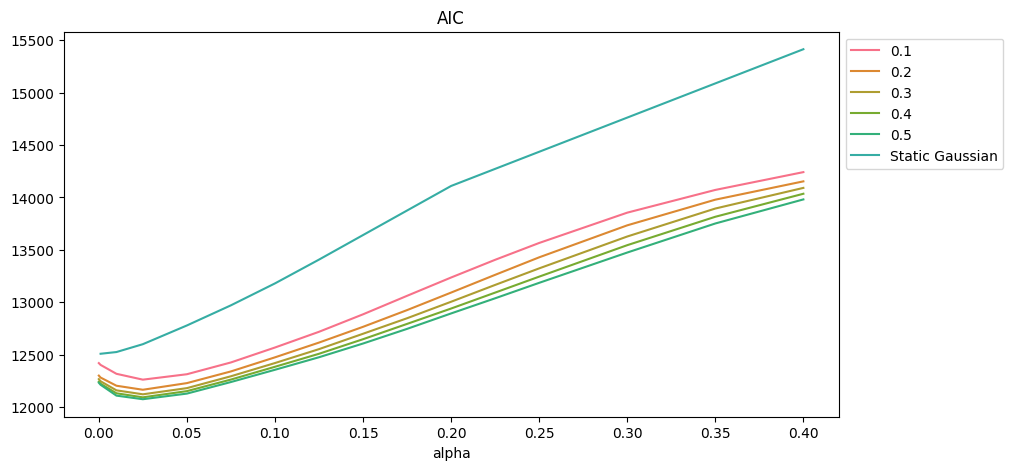

In [23]:
_,_ = plot_stat('AIC', [val for val in d_gaussian_50_ew.values()] + [static_gaussian_port_info], [0.1, 0.2,0.3,0.4,0.5] + ['Static Gaussian'])



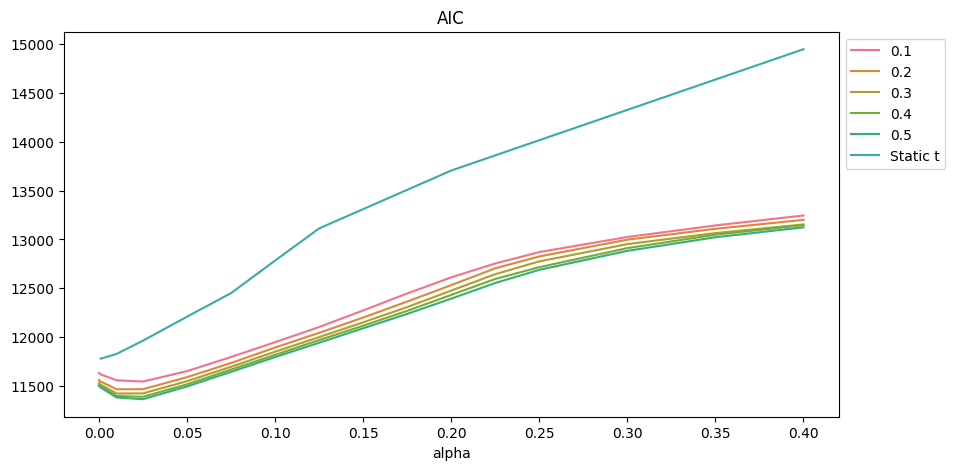

In [26]:
_,_ = plot_stat('AIC', [val for val in d_t_50_ew.values()] + [static_t_port_info], [0.1, 0.2,0.3,0.4,0.5] + ['Static t'])

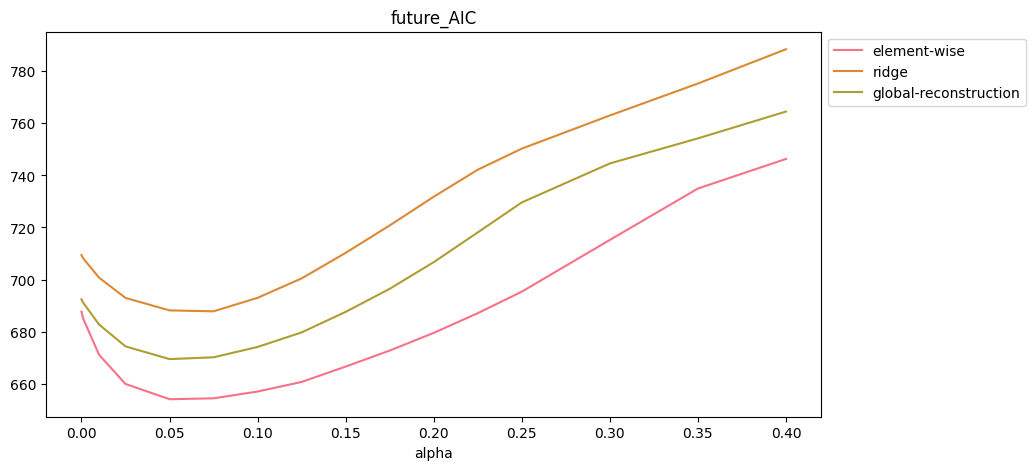

In [27]:
_,_ = plot_stat('future_AIC', [val for val in [d_gaussian_50_ew['0.4'], d_gaussian_50_ridge['0.4'], d_gaussian_50_gr['0.4']]], ['element-wise', 'ridge', 'global-reconstruction'])

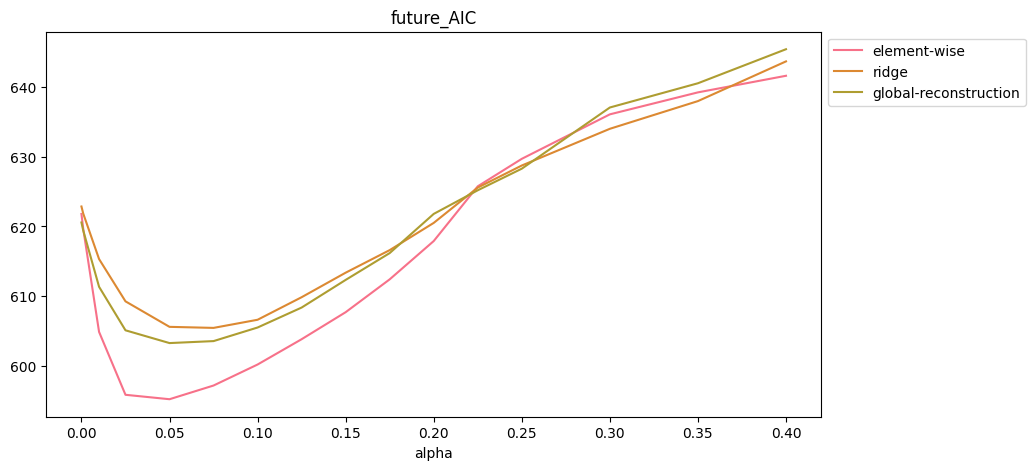

In [28]:
_,_ = plot_stat('future_AIC', [val for val in [d_t_50_ew['0.4'], d_t_50_ridge['0.4'], d_t_50_gr['0.4']]], ['element-wise', 'ridge', 'global-reconstruction'])

Compare portfolio Statistics

Test arima

In [88]:
with open(f'../data/case_study_etf/gaussian_nr_quad_5_etf_arima_static_l_20.pkl', 'rb') as handle:
    g_arima = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_5_etf_arima_static_l_20.pkl', 'rb') as handle:
    t_arima = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_5_etf_garch_static_l_20.pkl', 'rb') as handle:
    g_garch = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_5_etf_garch_static_l_20.pkl', 'rb') as handle:
    t_garch = pickle.load(handle)




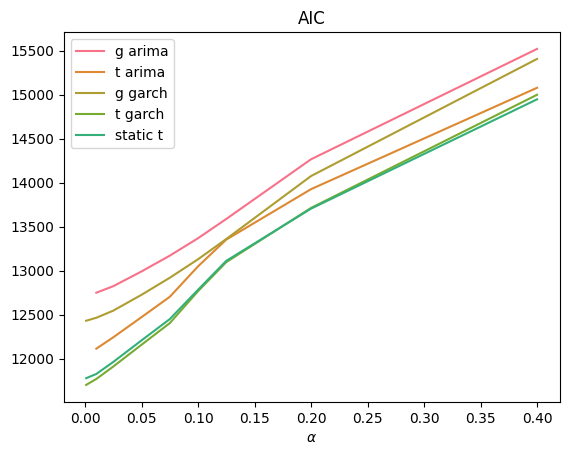

In [90]:
fig, ax = plt.subplots(1,1)
_,_ = plot_stat('AIC', [g_arima, t_arima, g_garch, t_garch, static_t_port_info], ['g arima', 't arima', 'g garch', 't garch', 'static t'], ax = ax)
ax.legend()

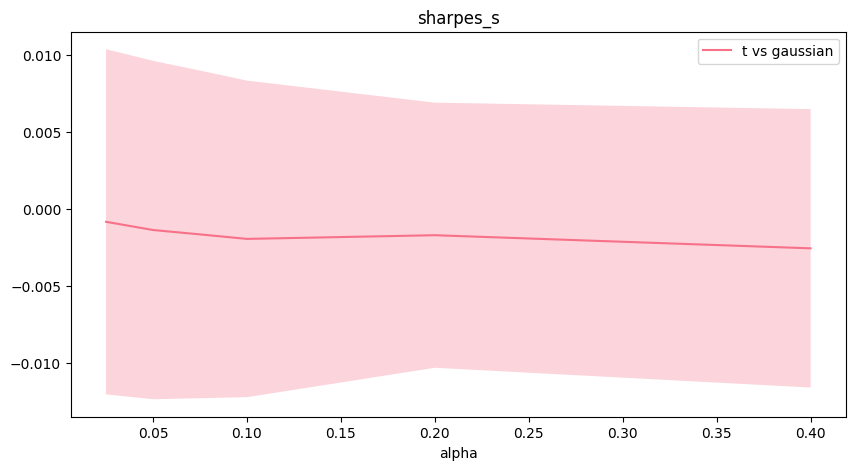

In [365]:

var = 'sharpes_s'



var_agg_tvsg = []
var_agg_std_tvsg = []

var_agg_gtvsg = []
var_agg_std_gtvsg = []


for cnt, alpha in enumerate(static_gaussian_port['alphas']):
    arr = np.array(np.array(static_t_port[var][cnt])-static_gaussian_port[var][cnt])
    var_agg_tvsg.append(np.mean(arr))
    var_agg_std_tvsg.append(np.std(arr))
var_agg_tvsg = np.array(var_agg_tvsg)
var_agg_std_tvsg = np.array(var_agg_std_tvsg)

# alpha_gt = []
# for cnt, alpha in enumerate(static_gt_port['alphas']):
#     cnt_n = np.where(np.array(static_gaussian_port['alphas']) == alpha)[0]
#     if len(cnt_n)<1:
#         continue
#     else:
#         cnt_n = np.where(np.array(static_gaussian_port['alphas']) == alpha)[0][0]
#     arr = np.array(np.array(static_t_port[var][cnt])-static_gaussian_port[var][cnt_n])
#     var_agg_gtvsg.append(np.mean(arr))
#     var_agg_std_gtvsg.append(np.std(arr))
#     alpha_gt.append(alpha)
# var_agg_gtvsg = np.array(var_agg_gtvsg)
# var_agg_std_gtvsg = np.array(var_agg_std_gtvsg)


# static_gt_port['alphas']

# for cnt, alpha in enumerate(static_sgt_port['alphas']): 
#     var_agg_sgt.append(np.median(static_sgt_port_info[var][cnt]))

# for cnt, alpha in enumerate(d_t_port['alphas']): 
#     var_agg_d_t.append(np.mean(d_t_port[var][cnt]))
# for cnt, alpha in enumerate(d_t_port2['alphas']): 
#     var_agg_d_t2.append(np.mean(d_t_port2[var][cnt]))
# for cnt, alpha in enumerate(d_gaussian_port['alphas']): 
#     var_agg_d_n.append(np.mean(d_t_port2[var][cnt]))

# for cnt, alpha in enumerate(static_gaussian_port['alphas']):
#     var_agg_cov.append(np.median(cov_port_info[var][0]))
# for cnt, alpha in enumerate(static_gaussian_port['alphas']):
#     var_agg_lw.append(np.median(lw_port_info[var][0]))
        

clrs = sns.color_palette("husl", 5)
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], var_agg_tvsg, label = 't vs gaussian', c = clrs[0])
ax.fill_between(static_gaussian_port['alphas'], var_agg_tvsg-var_agg_std_tvsg, var_agg_tvsg+var_agg_std_tvsg ,alpha=0.3, facecolor=clrs[0])
#ax.plot(alpha_gt, var_agg_gtvsg, label = 't vs gaussian', c = clrs[1])
#ax.fill_between(alpha_gt, var_agg_gtvsg-var_agg_std_gtvsg, var_agg_gtvsg+var_agg_std_gtvsg ,alpha=0.3, facecolor=clrs[1])
#ax.plot(static_gaussian_port['alphas'], var_agg_gtvsg, label = 'gt vs gaussian', c = clrs[1])
#ax.fill_between(static_gaussian_port['alphas'], var_agg_gtvsg-var_agg_std_gtvsg, var_agg_gtvsg+var_agg_std_gtvsg ,alpha=0.3, facecolor=clrs[1])
#ax.plot(static_t_port['alphas'], var_agg_t, label = 'static t', c = clrs[1])
#ax.fill_between(static_t_port['alphas'], var_agg_t-var_agg_std_t, var_agg_t+var_agg_std_t ,alpha=0.3, facecolor=clrs[1])
# ax.plot(static_gt_port['alphas'], var_agg_gt, label = 'static group t')
#ax.scatter(static_sgt_port['alphas'], var_agg_sgt, label = 'static skew  group t')

#ax.plot(d_t_port['alphas'], var_agg_d_t, label = 'dynamic t')
#ax.plot(d_t_port['alphas'], var_agg_d_n, label = 'dynamic Gaussian')

#ax.plot(static_gaussian_port['alphas'], var_agg_cov, label = 'Covariance')
#ax.plot(static_gaussian_port['alphas'], var_agg_lw, label = 'LedoitWolf')
# ax.plot(d_t_port2['alphas'], var_agg_d_t2, label = 'dynamic t 2')
ax.set_title(var)
ax.set_xlabel("alpha")
ax.legend(bbox_to_anchor = (1,1))


In [45]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.1_disjoint_100_element-wise.pkl', 'rb') as handle:
    d_port1 = pickle.load(handle)
    d_port1_info = extract_info_dynamic(d_port1,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.2_disjoint_100_element-wise.pkl', 'rb') as handle:
    d_port2 = pickle.load(handle)
    d_port2_info = handle(d_port2,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.3_disjoint_100_element-wise.pkl', 'rb') as handle:
    d_port3 = pickle.load(handle)
    d_port3_info = handle(d_port3,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.4_disjoint_100_element-wise.pkl', 'rb') as handle:
    d_port4 = pickle.load(handle)
    d_port4_info = extract_info(d_port4,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.5_disjoint_100_element-wise.pkl', 'rb') as handle:
    d_port5 = pickle.load(handle)
    d_port5_info = handle(d_port5,'gaussian', False)




i 500, alpha 0.025:   0%|          | 0/324 [3:21:34<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [278]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.1_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port1_50 = pickle.load(handle)
    d_port1_50_info = extract_info(d_port1_50,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.2_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port2_50 = pickle.load(handle)
    d_port2_50_info = extract_info(d_port2_50,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.3_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port3_50 = pickle.load(handle)
    d_port3_50_info = extract_info(d_port3_50,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.4_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port4_50 = pickle.load(handle)
    d_port4_50_info = extract_info(d_port4_50,'gaussian', False)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.5_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_port5_50 = pickle.load(handle)
    d_port5_50_info = extract_info(d_port5_50,'gaussian', False)


i 1580, alpha 0.4: 100%|██████████| 880/880 [00:44<00:00, 19.57it/s]  


In [277]:
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_100_element-wise.pkl', 'rb') as handle:
    dt_port1 = pickle.load(handle)
    dt_port1_info = extract_info(dt_port1,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.2_disjoint_100_element-wise.pkl', 'rb') as handle:
    dt_port2 = pickle.load(handle)
    dt_port2_info = extract_info(dt_port2,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.3_disjoint_100_element-wise.pkl', 'rb') as handle:
    dt_port3 = pickle.load(handle)
    dt_port3_info = extract_info(dt_port3,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.4_disjoint_100_element-wise.pkl', 'rb') as handle:
    dt_port4 = pickle.load(handle)
    dt_port4_info = extract_info(dt_port4,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.5_disjoint_100_element-wise.pkl', 'rb') as handle:
    dt_port5 = pickle.load(handle)
    dt_port5_info = extract_info(dt_port5,'gaussian', False)

i 1580, alpha 0.4: 100%|██████████| 880/880 [00:45<00:00, 19.39it/s]  


In [280]:
# with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50_element-wise.pkl', 'rb') as handle:
#     dt_port1_50 = pickle.load(handle)
#     dt_port1_50_info = extract_info(dt_port1_50,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.2_disjoint_50_element-wise.pkl', 'rb') as handle:
    dt_port2_50 = pickle.load(handle)
    dt_port2_50_info = extract_info(dt_port2_50,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.3_disjoint_50_element-wise.pkl', 'rb') as handle:
    dt_port3_50 = pickle.load(handle)
    dt_port3_50_info = extract_info(dt_port3_50,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.4_disjoint_50_element-wise.pkl', 'rb') as handle:
    dt_port4_50 = pickle.load(handle)
    dt_port4_50_info = extract_info(dt_port4_50,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.5_disjoint_50_element-wise.pkl', 'rb') as handle:
    dt_port5_50 = pickle.load(handle)
    dt_port5_50_info = extract_info(dt_port5_50,'gaussian', False)

i 1580, alpha 0.4: 100%|██████████| 880/880 [00:49<00:00, 17.87it/s]


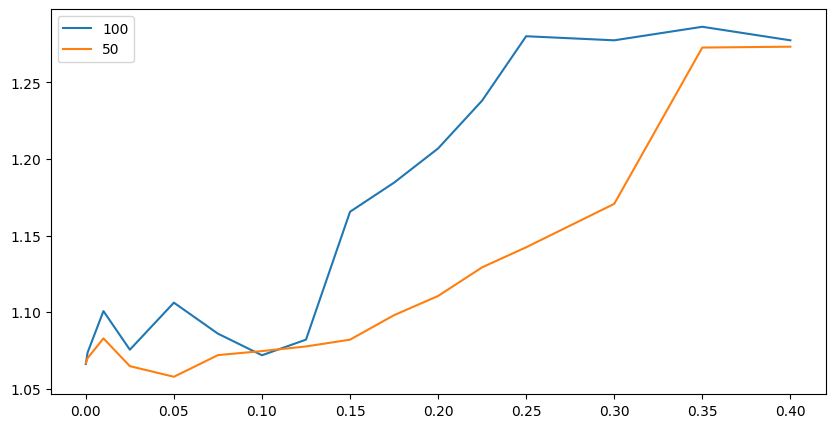

In [286]:
var = 'omegas_s'

var_agg_1 = []
var_agg_2 = []


for cnt, alpha in enumerate(d_port3['alphas']):
    var_agg_1.append(np.median(dt_port3_info[var][cnt]))
for cnt, alpha in enumerate(d_port3_50['alphas']):
    var_agg_2.append(np.median(d_port3_50_info[var][cnt]))


      
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(d_port1['alphas'], var_agg_1, label = '100')
ax.plot(d_port2['alphas'], var_agg_2, label = '50')
ax.legend()

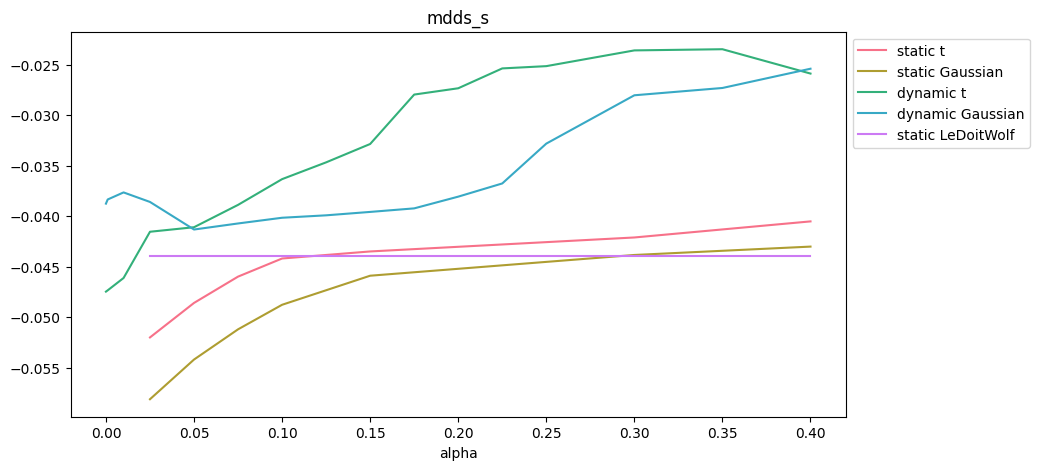

In [387]:
var = 'mdds_s'

var_agg_1 = []
var_agg_2 = []
var_agg_3 = []
var_agg_4 = []
var_agg_5 = []

for cnt, alpha in enumerate(d_port1['alphas']):
    var_agg_1.append(np.median(d_port1_info[var][cnt]))
for cnt, alpha in enumerate(d_port2['alphas']):
    var_agg_2.append(np.median(d_port2_info[var][cnt]))
for cnt, alpha in enumerate(d_port3['alphas']):
    var_agg_3.append(np.median(d_port3_info[var][cnt]))
for cnt, alpha in enumerate(d_port4['alphas']):
    var_agg_4.append(np.median(d_port4_info[var][cnt]))
for cnt, alpha in enumerate(d_port5['alphas']):
    var_agg_5.append(np.median(d_port5_info[var][cnt]))



var_agg_t1 = []
var_agg_t2 = []
var_agg_t3 = []
var_agg_t4 = []
var_agg_t5 = []

for cnt, alpha in enumerate(dt_port1['alphas']):
    var_agg_t1.append(np.median(dt_port1_info[var][cnt]))
for cnt, alpha in enumerate(dt_port2['alphas']):
    var_agg_t2.append(np.median(dt_port2_info[var][cnt]))
for cnt, alpha in enumerate(dt_port3['alphas']):
    var_agg_t3.append(np.median(dt_port3_info[var][cnt]))
for cnt, alpha in enumerate(dt_port4['alphas']):
    var_agg_t4.append(np.median(dt_port4_info[var][cnt]))
for cnt, alpha in enumerate(dt_port5['alphas']):
    var_agg_t5.append(np.median(dt_port5_info[var][cnt]))


var_agg_n = []
var_agg_std_n = []
var_agg_t = []
var_agg_std_t = []
var_agg_gt = []
var_agg_sgt = []
var_agg_d_t2 = []
var_agg_d_t = []
var_agg_d_n = []
var_agg_cov = []
var_agg_lw =[]
for cnt, alpha in enumerate(static_gaussian_port['alphas']):
    var_agg_n.append(np.mean(static_gaussian_port[var][cnt]))
    var_agg_std_n.append(np.std(static_gaussian_port[var][cnt]))
var_agg_n = np.array(var_agg_n)
var_agg_std_n = np.array(var_agg_std_n)
for cnt, alpha in enumerate(static_t_port['alphas']): 
    var_agg_t.append(np.mean(static_t_port[var][cnt]))
    var_agg_std_t.append(np.std(static_t_port[var][cnt]))
var_agg_t = np.array(var_agg_t)
var_agg_std_t = np.array(var_agg_std_t)


for cnt, alpha in enumerate(static_gaussian_port['alphas']):
    var_agg_lw.append(np.median(lw_port_info[var][0]))
      
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], var_agg_t, c = clrs[0], label = 'static t')
ax.plot(static_t_port['alphas'], var_agg_n, c = clrs[1], label = 'static Gaussian')
ax.plot(dt_port3['alphas'], var_agg_t3, c = clrs[2], label = 'dynamic t')
ax.plot(d_port3['alphas'], var_agg_3, c = clrs[3], label = 'dynamic Gaussian')
ax.plot(static_gaussian_port['alphas'], var_agg_lw, c = clrs[4], label = 'static LeDoitWolf')

# ax.plot(d_t_port2['alphas'], var_agg_d_t2, label = 'dynamic t 2')
ax.set_title(var)
ax.set_xlabel("alpha")
ax.legend(bbox_to_anchor = (1,1))




      
# fig, ax = plt.subplots(1,1,figsize = (10,5))
# ax.plot(dt_port1['alphas'], var_agg_t1, label = '0.1')
# ax.plot(dt_port2['alphas'], var_agg_t2, label = '0.2')
# ax.plot(dt_port3['alphas'], var_agg_t3, label = '0.3')
# ax.plot(dt_port4['alphas'], var_agg_t4, label = '0.4')
# ax.plot(dt_port5['alphas'], var_agg_t5, label = '0.5')

# # ax.plot(d_t_port2['alphas'], var_agg_d_t2, label = 'dynamic t 2')
# ax.set_title(var)
# ax.set_xlabel("alpha")
# ax.legend(bbox_to_anchor = (1,1))

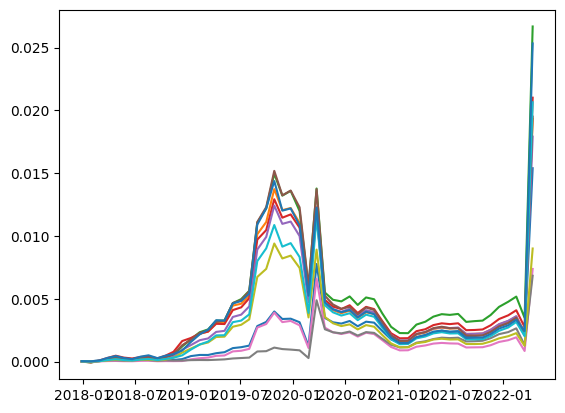

In [80]:
plt.plot(static_sgt_port['time_change'],static_sgt_port['gammas'][0])

### Plot degrees of freedom

NameError: name 't_port' is not defined

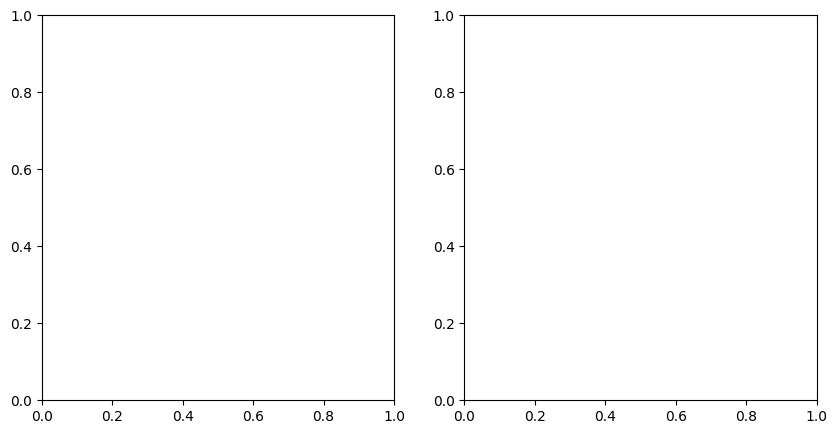

In [2]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(t_port['time_change'],t_port['nus'][0])


ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,0])
ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,1])
ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,6])
fig.autofmt_xdate()


### plot MDD

Compare Static

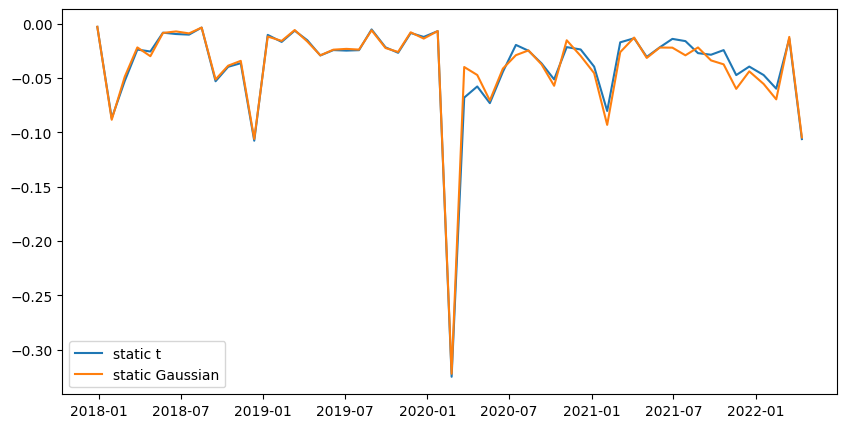

In [7]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)


k = 1

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_t_port['time_change'], static_t_port['mdds_m'][k], label = 'static t')
ax.plot(static_gaussian_port['time_change'], static_gaussian_port['mdds_m'][k], label = 'static Gaussian')
# ax.plot(static_gt_port['time_change'][:len(static_gt_port['mdds_s'][0])], static_gt_port['mdds_s'][0], label = 'static Gaussian')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

Compare alpha

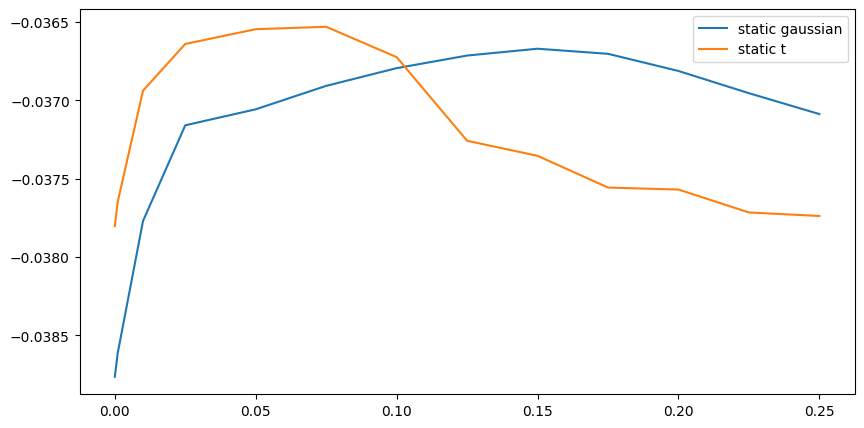

In [8]:



with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['mdds_m'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['mdds_m'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()


Compare Dynamic

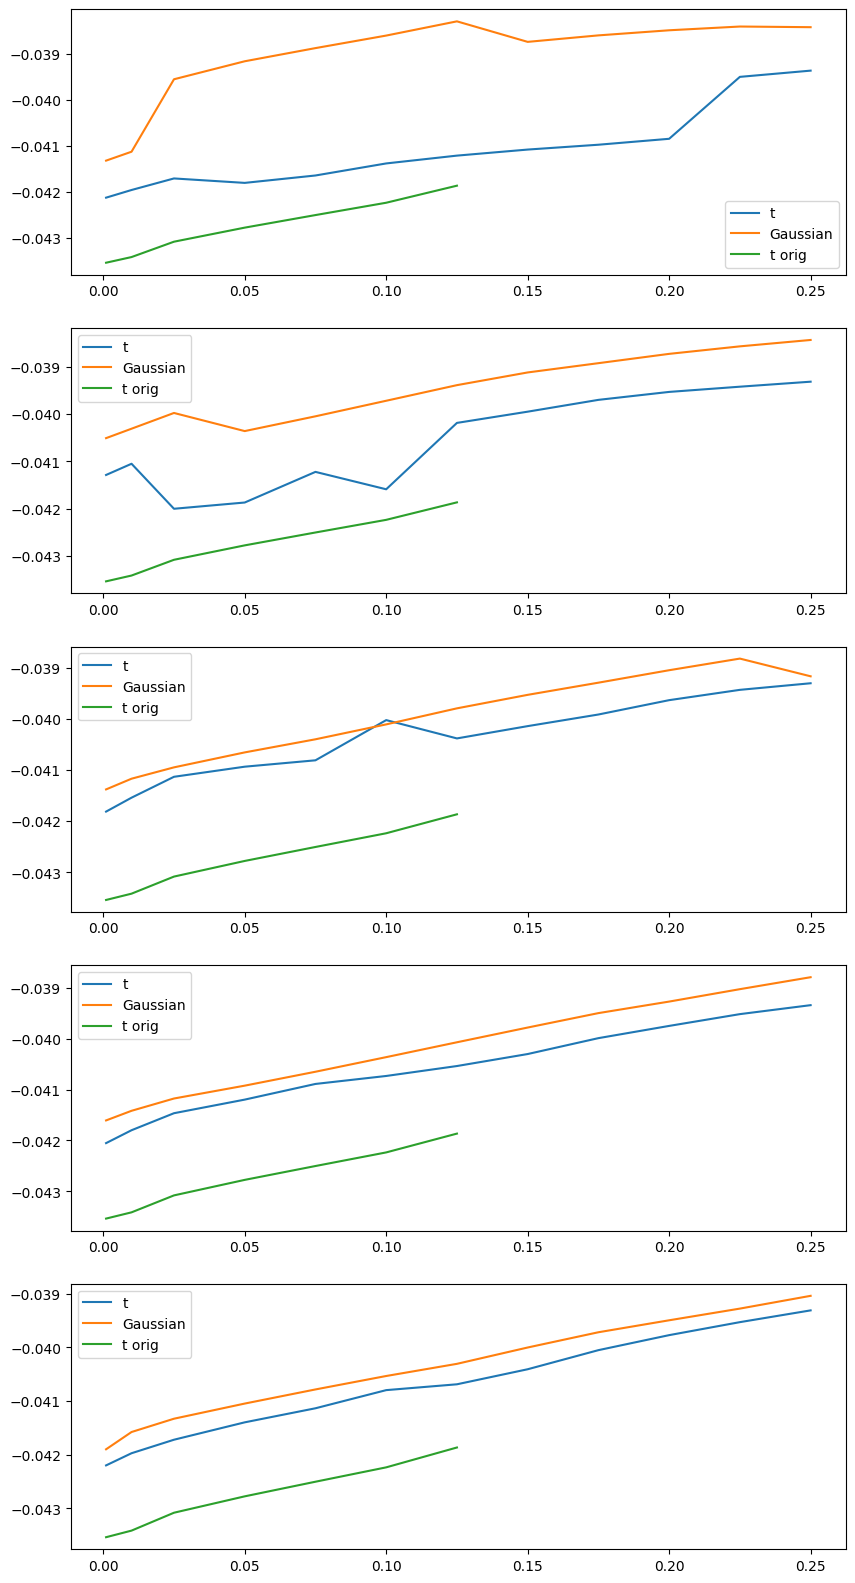

In [43]:
t_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['mdds_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['mdds_s'][cnt]))
    
    n_port.append(mean_mdd_n)

    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['mdds_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)




fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')

    ax[cnt].legend()


Compare temporal 

c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


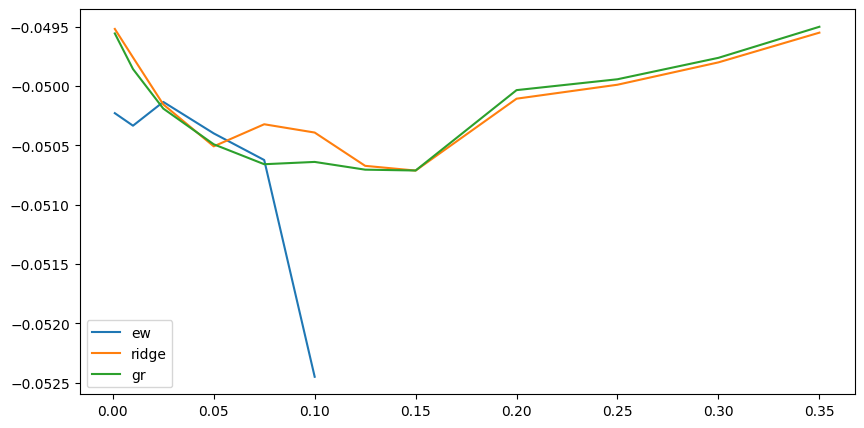

In [46]:


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_20.pkl', 'rb') as handle:
    t_port_ew = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_20_ridge.pkl', 'rb') as handle:
    t_port_ridge = pickle.load(handle)


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_20_global-reconstruction.pkl', 'rb') as handle:
    t_port_gr = pickle.load(handle)

mean_mdd_ew = []
for cnt, alpha in enumerate(t_port_ew['alphas']):
    mean_mdd_ew.append(np.mean(t_port_ew['mdds_s'][cnt]))
mean_mdd_ridge = []
for cnt, alpha in enumerate(t_port_ridge['alphas']):
    mean_mdd_ridge.append(np.mean(t_port_ridge['mdds_s'][cnt]))
mean_mdd_gr = []
for cnt, alpha in enumerate(t_port_gr['alphas']):
    mean_mdd_gr.append(np.mean(t_port_gr['mdds_s'][cnt]))


fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(t_port_ew['alphas'], mean_mdd_ew, label = f'ew')
ax.plot(t_port_ridge['alphas'], mean_mdd_ridge, label = f'ridge')
ax.plot(t_port_gr['alphas'], mean_mdd_gr, label = f'gr')


ax.legend()

### Plot weights

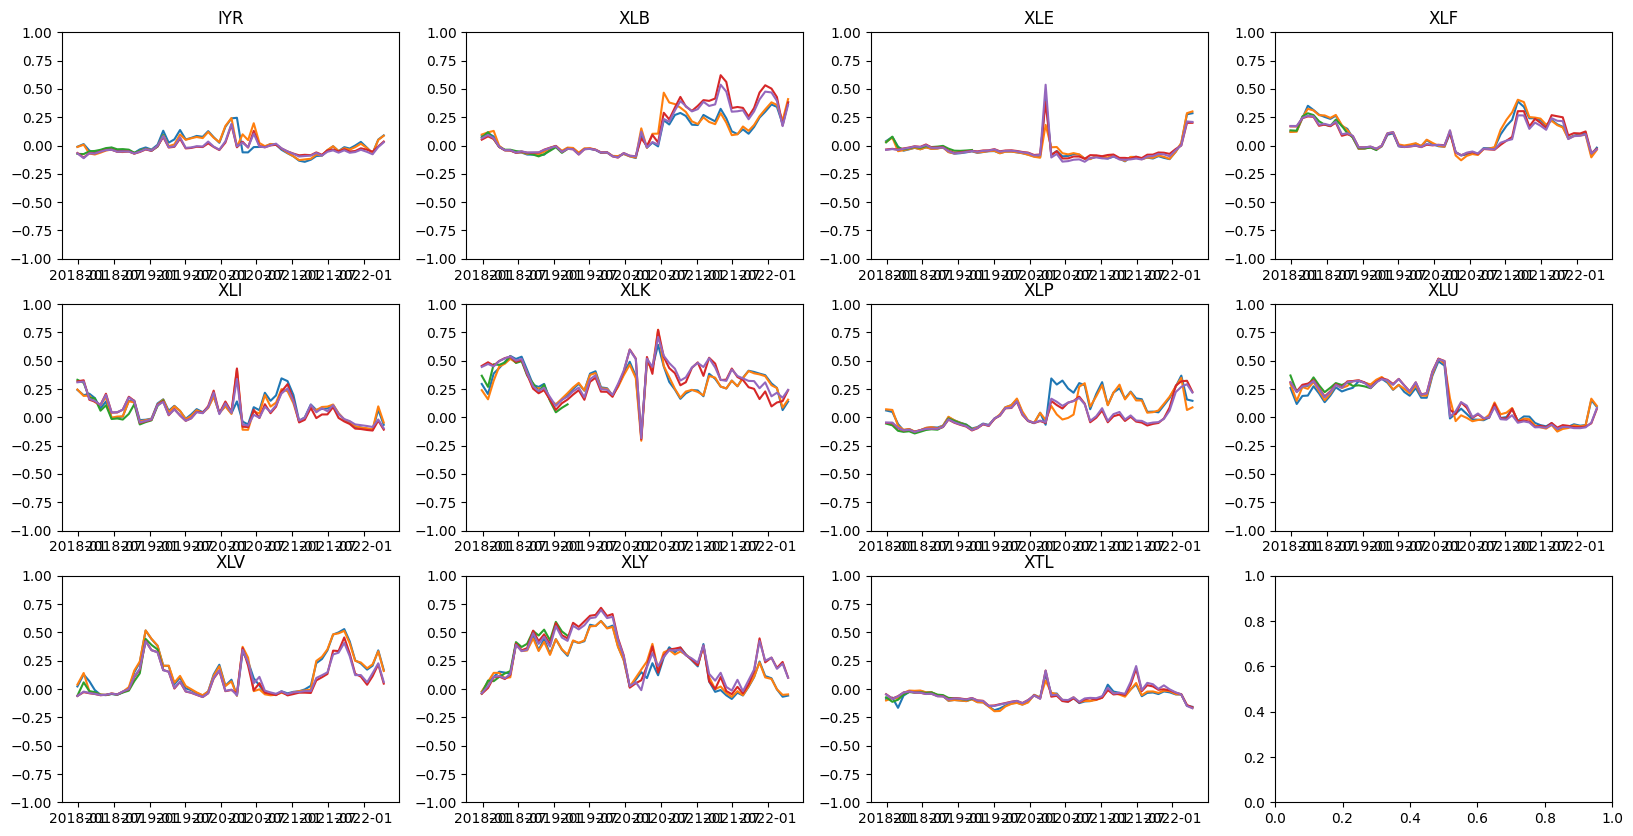

In [82]:
fig, ax = plt.subplots(3,4,figsize = (20,10))
k_n = 3
k_t = 3

w_t_s = np.array(t_port['ws_s'][k_n])
w_n_s = np.array(gaussian_port['ws_s'][k_t])
w_gt_s = np.array(gt_port['ws_s'][0])
w_cov_s = np.array(cov_port['ws_s'][0])
w_lw_s = np.array(LedoitWolf_port['ws_s'][0])

cnt = 0
for i in range(3):
    for j in range(4):
        if cnt == 11:
            break

        ax[i,j].plot(t_port['time_change'], w_t_s[:,cnt], label = 't')
        ax[i,j].plot(gaussian_port['time_change'], w_n_s[:,cnt], label = 'n')
        ax[i,j].plot(gt_port['time_change'][:len(w_gt_s[:,cnt])], w_gt_s[:,cnt], label = 'gt')
        ax[i,j].plot(cov_port['time_change'], w_cov_s[:,cnt], label = 'cov')
        ax[i,j].plot(LedoitWolf_port['time_change'], w_lw_s[:,cnt], label = 'lw')
        ax[i,j].set_title(t_port['X'].columns[cnt])
        ax[i,j].set_ylim((-1,1))

        cnt +=1




### plot cumulative return

In [3]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]


[*********************100%***********************]  1 of 1 completed


In [4]:
import yfinance as yf

ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
start_date= "2016-01-01"
end_date="2023-02-01"

data_etf = yf.download(ticker_list, start_date , end_date)
data_etf_u = data_etf['Adj Close'].sum(axis=1)/data_etf.shape[1]

log_returns_etf = np.log(1+data_etf['Adj Close'].pct_change()).dropna()
log_returns_etf_scaled = 100*log_returns_etf.copy()#scaler.fit_transform(log_returns)
price_etf = data_etf['Adj Close'].iloc[1:]
price_etf_u = price_etf.sum(axis=1)/price_etf.shape[1]


[*********************100%***********************]  11 of 11 completed


In [24]:
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


Compare static

In [ ]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port_no_w = pickle.load(handle)
    static_gaussian_port_no_w_out = extract_info(static_gaussian_port_no_w, 'gaussian', False)
    
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port_no_w = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

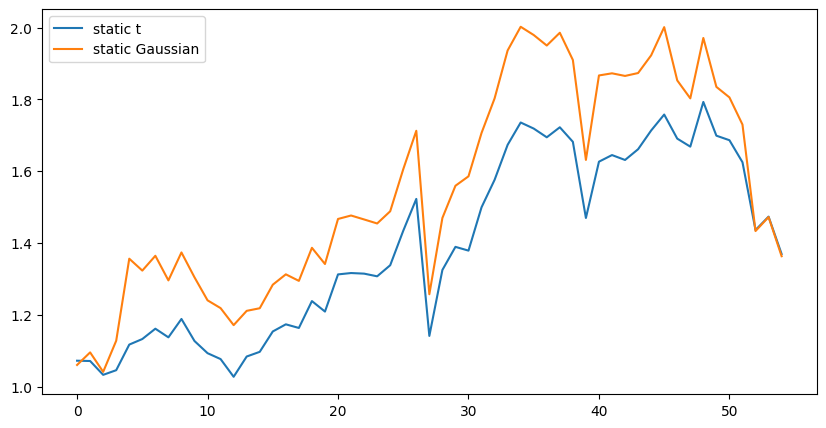

In [63]:


k = 1
#s_t_price_no_w = cum_prod_port(static_t_port_no_w['port_price_s'][k]) 
#s_n_price_no_w = cum_prod_port(static_gaussian_port_no_w['port_price_s'][k]) 
s_t_price = np.cumprod(1+np.array(static_gt_port_info['rs_s'][k])) #cum_prod_port(static_t_port_info['port_price_s'][k]) 
s_n_price = np.cumprod(1+np.array(static_gaussian_port_info['rs_s'][k]))# cum_prod_port(static_gaussian_port_info['port_price_s'][k]) 
#s_gt_price = cum_prod_port(static_gt_port['port_price_s'][0]) 


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(s_t_price, label = 'static t')
ax.plot( s_n_price, label = 'static Gaussian')

#ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price, label = 'static t')
#ax.plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price)], s_n_price, label = 'static Gaussian')
#ax.plot(np.concatenate(static_t_port_no_w['time_forecast'][0])[:len(s_t_price_no_w)], s_t_price_no_w, label = 'static t _no_w')
#ax.plot(np.concatenate(static_gaussian_port_no_w['time_forecast'][0])[:len(s_n_price_no_w)], s_n_price_no_w, label = 'static Gaussian _no_w')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

Compare Dynamic

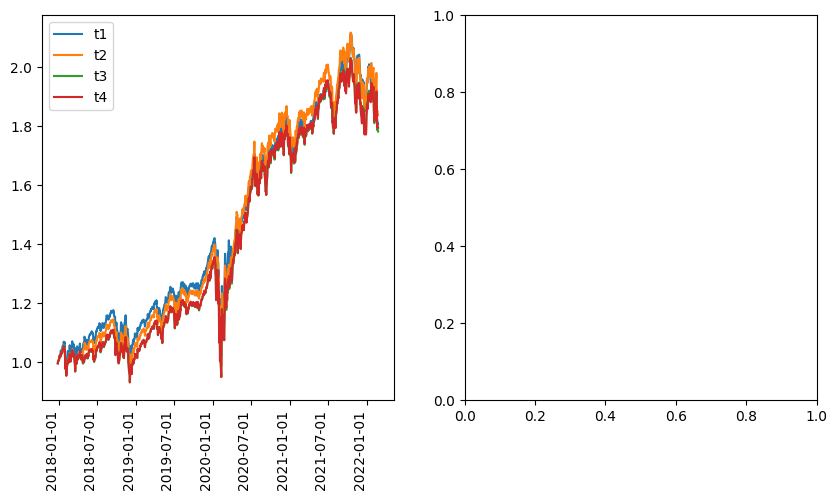

In [20]:
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_20.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.3_disjoint_20.pkl', 'rb') as handle:
    t_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.4_disjoint_20.pkl', 'rb') as handle:
    t_port3 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.5_disjoint_20.pkl', 'rb') as handle:
    t_port4 = pickle.load(handle)

# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.1_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port1 = pickle.load(handle)
# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.3_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port2 = pickle.load(handle)
# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.4_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port3 = pickle.load(handle)
# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.5_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port4 = pickle.load(handle)

k = 3
s_t_price1 = cum_prod_port(t_port1['port_price_s'][k]) 
s_t_price2 = cum_prod_port(t_port2['port_price_s'][k]) 
s_t_price3 = cum_prod_port(t_port3['port_price_s'][k]) 
s_t_price4 = cum_prod_port(t_port4['port_price_s'][k]) 

# s_n_price1 = cum_prod_port(gaussian_port1['port_price_s'][k]) 
# s_n_price2 = cum_prod_port(gaussian_port2['port_price_s'][k]) 
# s_n_price3 = cum_prod_port(gaussian_port3['port_price_s'][k]) 
# s_n_price4 = cum_prod_port(gaussian_port4['port_price_s'][k]) 

fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(np.concatenate(t_port1['time_forecast'][0])[:len(s_t_price1)], s_t_price1, label = 't1')
ax[0].plot(np.concatenate(t_port2['time_forecast'][0])[:len(s_t_price2)], s_t_price2, label = 't2')
ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

#ax[0].plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
#ax[0].plot(np.concatenate(gaussian_port2['time_forecast'][0])[:len(s_n_price2)], s_n_price2, label = 'gaussian2')
#ax[0].plot(np.concatenate(gaussian_port3['time_forecast'][0])[:len(s_n_price3)], s_n_price3, label = 'gaussian3')
#ax[0].plot(np.concatenate(gaussian_port4['time_forecast'][0])[:len(s_n_price4)], s_n_price4, label = 'gaussian4')

#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
#ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax[0].legend()

 Compare Dynamic Penalty

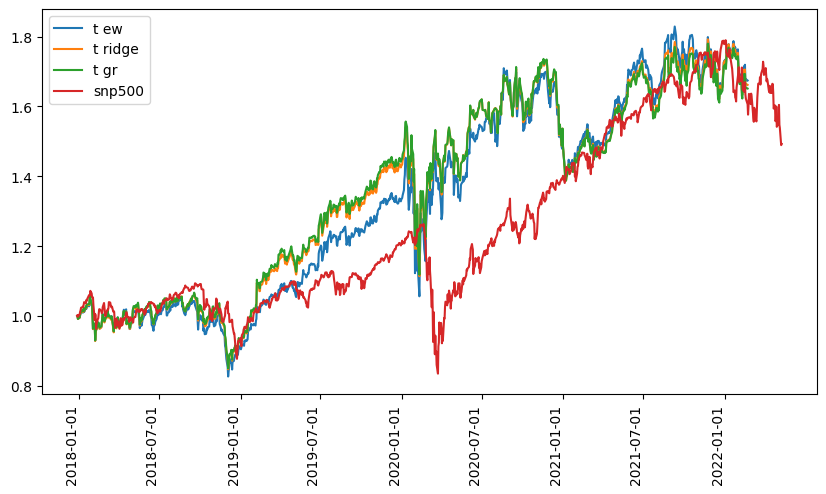

In [243]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.2_disjoint_20.pkl', 'rb') as handle:
    t_ew = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.2_disjoint_20_ridge.pkl', 'rb') as handle:
    t_ridge = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.2_disjoint_20_global-reconstruction.pkl', 'rb') as handle:
    t_gr = pickle.load(handle)


with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.2_disjoint_20.pkl', 'rb') as handle:
    n_ew = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.2_disjoint_20_ridge.pkl', 'rb') as handle:
    n_ridge = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.2_disjoint_20_global-reconstruction.pkl', 'rb') as handle:
    n_gr = pickle.load(handle)

k = 3
s_t_ew = cum_prod_port(t_ew['port_price_s'][k]) 
s_t_ridge = cum_prod_port(t_ridge['port_price_s'][k]) 
s_t_gr = cum_prod_port(t_gr['port_price_s'][k]) 

s_n_ew = cum_prod_port(n_ew['port_price_s'][k]) 
s_n_ridge = cum_prod_port(n_ridge['port_price_s'][k]) 
s_n_gr = cum_prod_port(n_gr['port_price_s'][k]) 

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(t_ew['time_forecast'][0])[:len(s_t_ew)], s_t_ew, label = 't ew')
ax.plot(np.concatenate(t_ridge['time_forecast'][0])[:len(s_t_ridge)], s_t_ridge, label = 't ridge')
ax.plot(np.concatenate(t_gr['time_forecast'][0])[:len(s_t_gr)], s_t_gr, label = 't gr')


#ax.plot(np.concatenate(n_ew['time_forecast'][0])[:len(s_n_ew)], s_n_ew, label = 'gaussian ew')
#ax.plot(np.concatenate(n_ridge['time_forecast'][0])[:len(s_n_ridge)], s_n_ridge, label = 'gaussian ridge')
#ax.plot(np.concatenate(n_gr['time_forecast'][0])[:len(s_n_gr)], s_n_gr, label = 'gaussian gr')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax.legend()

Compare alpha level

In [155]:
def plot_per_alpha(port):
    fig, ax = plt.subplots(1,1,figsize = (10,5))

    for cnt, alpha in enumerate(port['alphas']):
        if len(port['port_price_s'][cnt])<=0:
            continue
        s_price = cum_prod_port(port['port_price_s'][cnt]) 
        ax.plot(np.concatenate(port['time_forecast'][0])[:len(s_price)], s_price, label = f't {cnt}')


    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    #ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


    ax.legend()

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


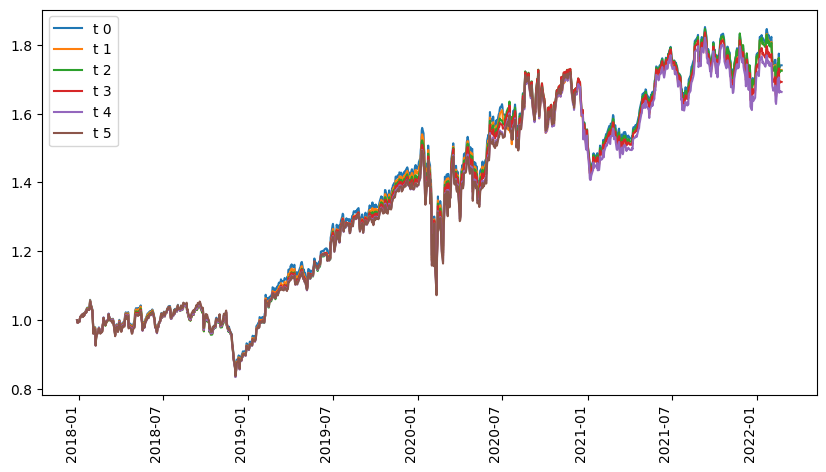

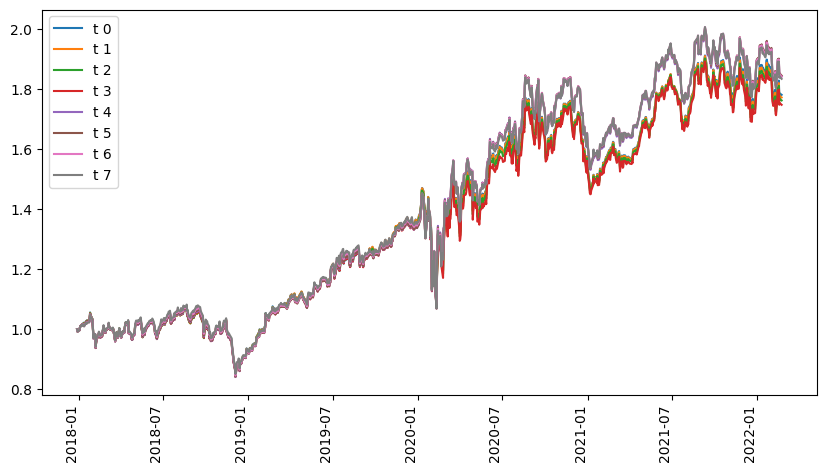

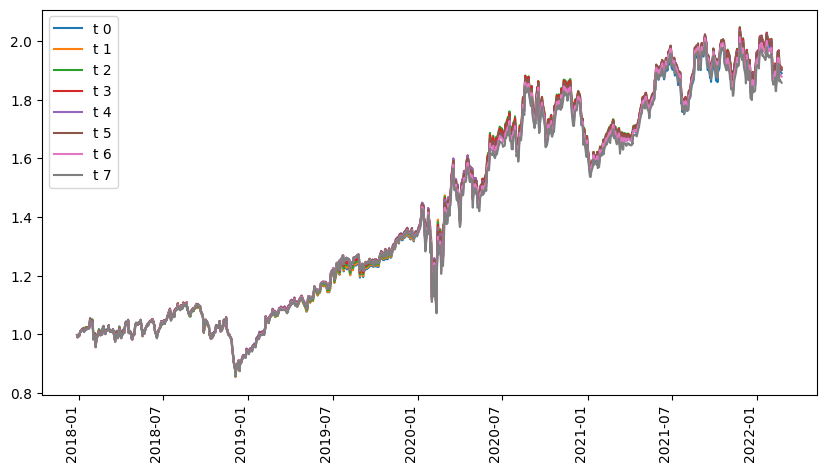

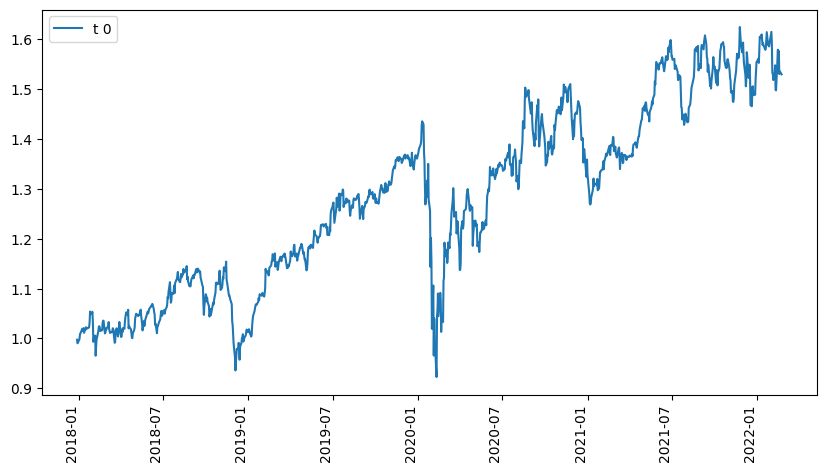

In [159]:


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{1}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


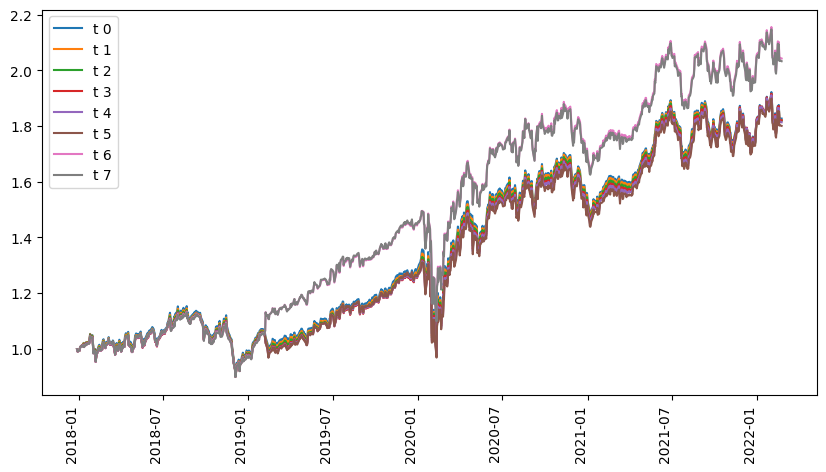

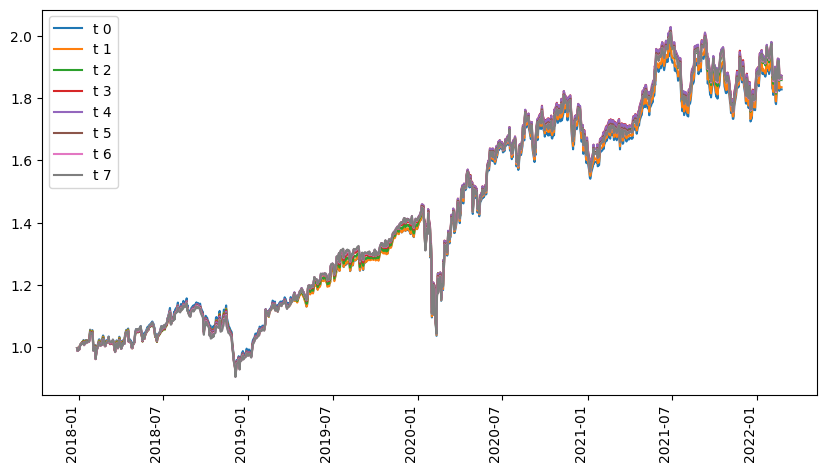

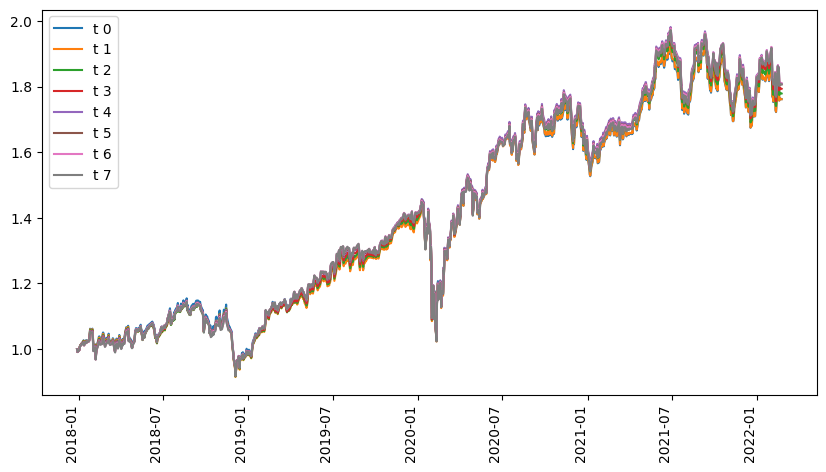

In [206]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_50.pkl', 'rb') as handle:
    port1 = pickle.load(handle)
plot_per_alpha(port1)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_50.pkl', 'rb') as handle:
    port2 = pickle.load(handle)
plot_per_alpha(port2)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_50.pkl', 'rb') as handle:
    port3 = pickle.load(handle)
plot_per_alpha(port3)


In [225]:
np.round(port3['thetas'][10][20][-1],2)

array([[ 0.61,  0.  , -0.01, -0.  , -0.  , -0.02, -0.  , -0.  , -0.01,
        -0.  , -0.  , -0.02, -0.02,  0.  , -0.05, -0.1 , -0.  ,  0.  ,
        -0.02, -0.01,  0.  , -0.02,  0.  ,  0.  ,  0.  ,  0.  , -0.01,
        -0.02, -0.  ,  0.  ],
       [ 0.  ,  0.98,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  , -0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  , -0.03, -0.38, -0.26, -0.  , -0.03,  0.  ,
         0.  ,  0.  ,  0.  ],
       [-0.01,  0.  ,  0.81, -0.  , -0.  , -0.04, -0.04, -0.01, -0.01,
        -0.  , -0.  , -0.03, -0.1 , -0.02, -0.04, -0.17,  0.  ,  0.  ,
        -0.04, -0.01, -0.  , -0.04,  0.  ,  0.  ,  0.  , -0.01, -0.  ,
        -0.02, -0.11, -0.  ],
       [-0.  ,  0.  , -0.  ,  0.28, -0.02, -0.  , -0.01, -0.  , -0.02,
        -0.  , -0.  , -0.04, -0.03, -0.  , -0.  , -0.04, -0.03,  0.  ,
        -0.  , -0.  , -0.01, -0.  ,  0.  ,  0.  ,  0.  , -0.01,  0.  ,
        -0.01, -0.  , -0.  ],
       [-0.  ,  0.  , -0.  ,

In [230]:
port3['fro_norms'][11]

[1.0868850329235066e-05,
 8.16083041572504e-06,
 6.305119966517903e-06,
 0.0648242145797843,
 6.453859940637246e-06,
 6.879004929818595e-06,
 4.0762005225143696e-05,
 0.10615099784192034,
 5.557794461410883e-06,
 0.06476067882008481,
 0.08703229073771207,
 0.0008053282527315887,
 8.965905918821836e-06,
 9.429229212181888e-06,
 7.430429045467448e-06,
 8.249220724460053e-06,
 1.3901355170722105e-05,
 8.639822469312907e-06,
 1.2187593452939597e-05,
 7.82818710023496e-06,
 8.640230116793925e-06,
 1.0343713180144122e-05,
 1.1149590004558042e-05,
 1.0812724484080347e-05,
 8.648326221502867e-06,
 7.864850785753312e-06,
 9.864651628249262e-06,
 8.291151025897484e-06,
 1.4319480110127503e-05,
 2.086041583120111e-05,
 1.7370197562072633e-05,
 1.9036267162486892e-05,
 2.5488725441411993e-05,
 2.0299321637644883e-05,
 2.2023257197434048e-05,
 1.8461968673482255e-05,
 1.6919812610153783e-05,
 1.656711662658576e-05,
 1.8770461056924743e-05,
 1.6824942808969313e-05,
 1.4587685218671017e-05,
 1.600384

In [233]:
scipy.linalg.norm(port3['thetas'][12][20][-1])

KeyError: 12

In [226]:
np.round(port3['thetas'][2][20][-1],2)

array([[ 1.08, -0.11, -0.  , -0.  ,  0.  , -0.05,  0.  ,  0.  , -0.01,
         0.  ,  0.  , -0.03, -0.05,  0.  , -0.11, -0.21, -0.01,  0.  ,
        -0.06, -0.01,  0.02, -0.09, -0.02,  0.  ,  0.03,  0.  , -0.02,
        -0.04, -0.02,  0.  ],
       [-0.11,  2.31, -0.07,  0.  ,  0.  ,  0.03,  0.  ,  0.  ,  0.03,
         0.  ,  0.02,  0.  , -0.09,  0.  ,  0.  ,  0.05,  0.  , -0.  ,
        -0.03,  0.  ,  0.  , -0.12, -1.15, -0.64,  0.  , -0.18,  0.  ,
         0.01,  0.  , -0.06],
       [-0.  , -0.07,  1.66,  0.  ,  0.  , -0.1 , -0.07, -0.02, -0.02,
        -0.01,  0.  , -0.05, -0.27, -0.01, -0.08, -0.38,  0.  ,  0.03,
        -0.12, -0.02,  0.  , -0.12,  0.  ,  0.  ,  0.  , -0.06,  0.  ,
        -0.02, -0.25, -0.03],
       [-0.  ,  0.  ,  0.  ,  0.43, -0.03, -0.  , -0.02, -0.  , -0.02,
        -0.01, -0.04, -0.07, -0.07,  0.  ,  0.02, -0.02, -0.07,  0.01,
         0.03, -0.  , -0.01,  0.  ,  0.05,  0.02,  0.  , -0.05, -0.02,
        -0.03, -0.  , -0.01],
       [ 0.  ,  0.  ,  0.  ,

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


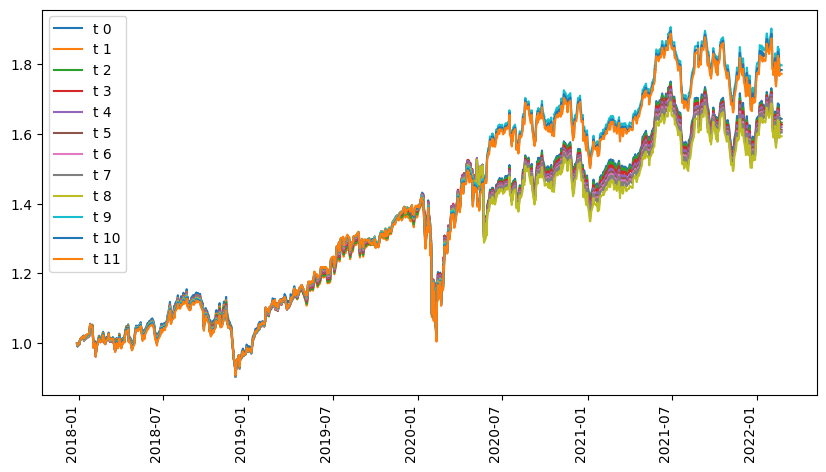

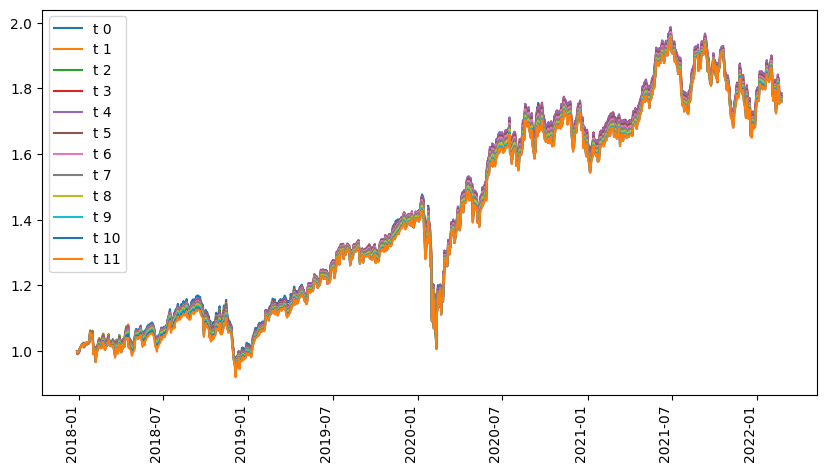

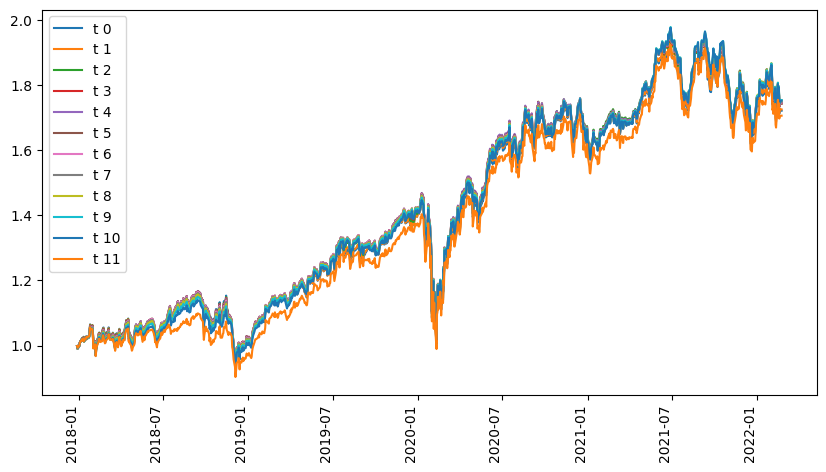

In [221]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_100.pkl', 'rb') as handle:
    port1 = pickle.load(handle)
plot_per_alpha(port1)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_100.pkl', 'rb') as handle:
    port2 = pickle.load(handle)
plot_per_alpha(port2)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_100.pkl', 'rb') as handle:
    port3 = pickle.load(handle)
plot_per_alpha(port3)

Compare different number of observations per graph

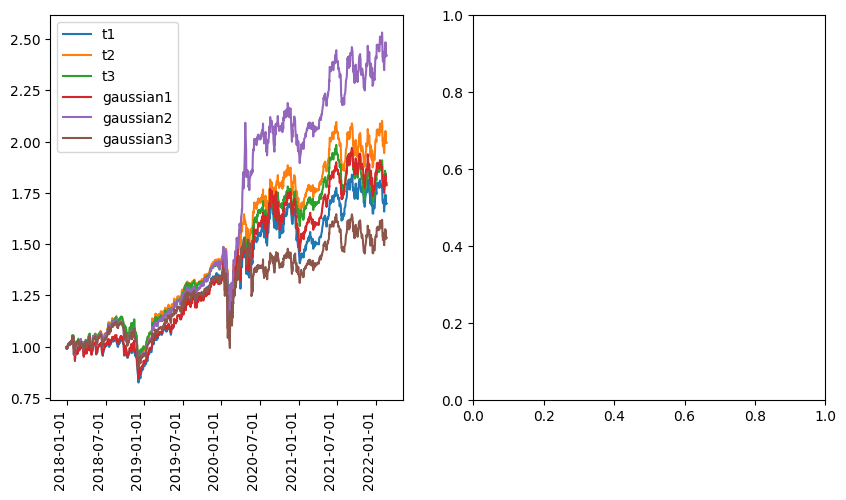

In [220]:
k = 0.2

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_20.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_50.pkl', 'rb') as handle:
    t_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_100.pkl', 'rb') as handle:
    t_port3 = pickle.load(handle)
#with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_250.pkl', 'rb') as handle:
#    t_port4 = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_20.pkl', 'rb') as handle:
    gaussian_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_50.pkl', 'rb') as handle:
    gaussian_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_100.pkl', 'rb') as handle:
    gaussian_port3 = pickle.load(handle)
#with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_250.pkl', 'rb') as handle:
#    gaussian_port4 = pickle.load(handle)



a = 2
s_t_price1 = cum_prod_port(t_port1['port_price_s'][a]) 
s_t_price2 = cum_prod_port(t_port2['port_price_s'][a]) 
s_t_price3 = cum_prod_port(t_port3['port_price_s'][a]) 
s_t_price4 = cum_prod_port(t_port4['port_price_s'][a]) 

s_n_price1 = cum_prod_port(gaussian_port1['port_price_s'][a]) 
s_n_price2 = cum_prod_port(gaussian_port2['port_price_s'][a]) 
s_n_price3 = cum_prod_port(gaussian_port3['port_price_s'][a]) 
s_n_price4 = cum_prod_port(gaussian_port4['port_price_s'][a]) 

fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(np.concatenate(t_port1['time_forecast'][0])[:len(s_t_price1)], s_t_price1, label = 't1')
ax[0].plot(np.concatenate(t_port2['time_forecast'][0])[:len(s_t_price2)], s_t_price2, label = 't2')
ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax[0].plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax[0].plot(np.concatenate(gaussian_port2['time_forecast'][0])[:len(s_n_price2)], s_n_price2, label = 'gaussian2')
ax[0].plot(np.concatenate(gaussian_port3['time_forecast'][0])[:len(s_n_price3)], s_n_price3, label = 'gaussian3')
#ax[0].plot(np.concatenate(gaussian_port4['time_forecast'][0])[:len(s_n_price4)], s_n_price4, label = 'gaussian4')

#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
#ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax[0].legend()

Compare best

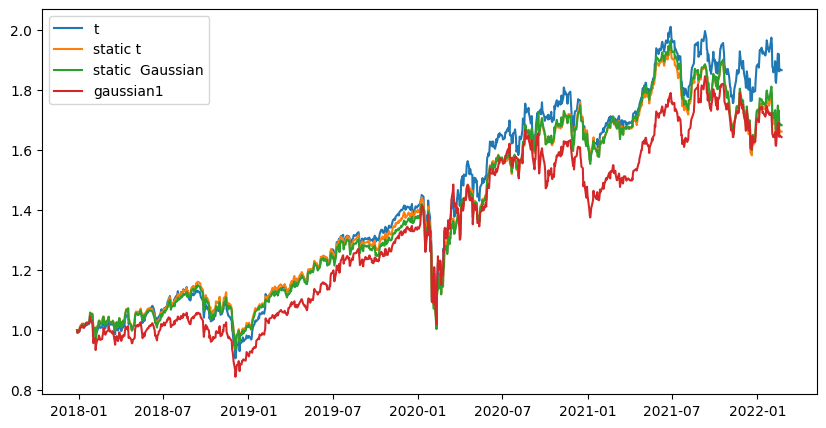

In [173]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_50.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)


t_price = cum_prod_port(t_port1['port_price_s'][7]) 
s_t_price = cum_prod_port(static_t_port['port_price_s'][6]) 
s_n_price = cum_prod_port(static_gaussian_port['port_price_s'][6]) 


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(t_port1['time_forecast'][0])[:len(t_price)], t_price, label = 't')
ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price, label = 'static t')
ax.plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price)], s_n_price, label = 'static  Gaussian')
#ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax.plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax.legend()

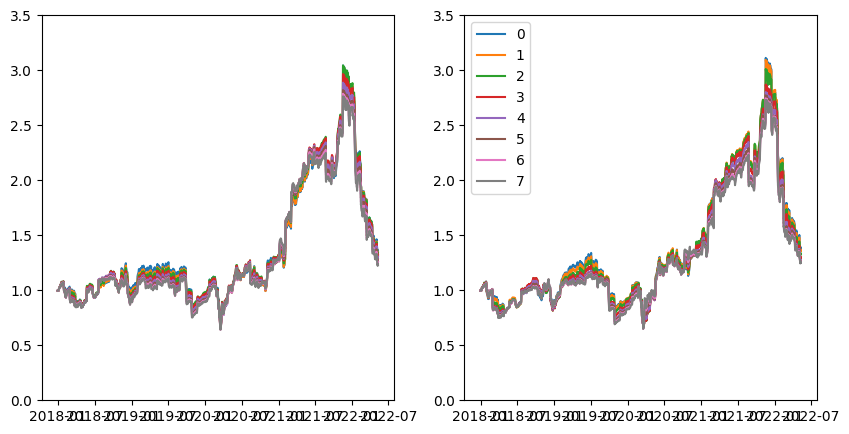

In [307]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0
for i in range(len(t_port['alphas'])):
    ax[0].plot(np.concatenate(t_port['time_forecast'][i])[1:], np.cumprod(1+pd.DataFrame(np.concatenate(t_port['port_price_s'][i])).pct_change().dropna()), label = i)
    ax[0].set_ylim((0,3.5))
for i in range(len(t_port['alphas'])):
    ax[1].plot(np.concatenate(gaussian_port['time_forecast'][i])[1:], np.cumprod(1+pd.DataFrame(np.concatenate(gaussian_port['port_price_s'][i])).pct_change().dropna()), label = i)
    ax[1].set_ylim((0,3.5))

ax[1].legend()

### Plot variance

static

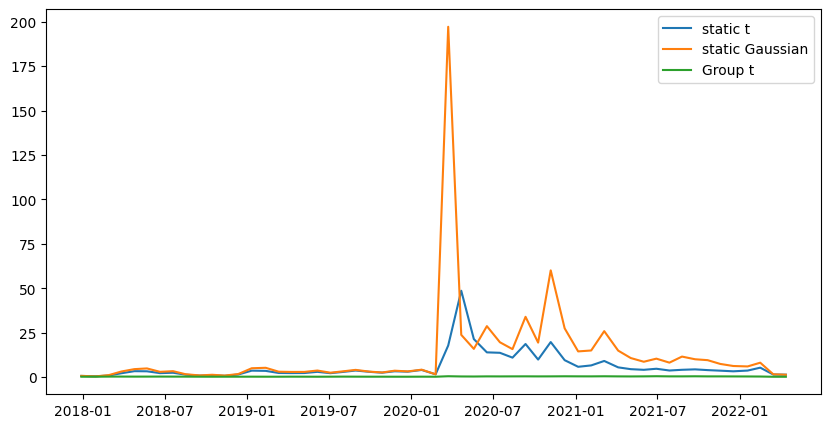

In [15]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

k = 2

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_t_port['time_change'], static_t_port['vars_s'][k], label = 'static t')
ax.plot(static_gaussian_port['time_change'], static_gaussian_port['vars_s'][k], label = 'static Gaussian')
ax.plot(static_gt_port['time_change'][:len(static_gt_port['vars_s'][0])], static_gt_port['vars_s'][0], label = 'Group t')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

alpha static

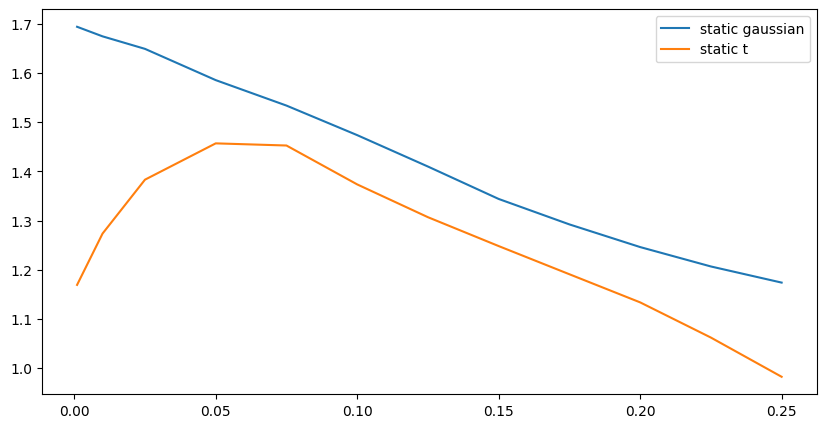

In [22]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['vars_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['vars_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()


Compare dynamic

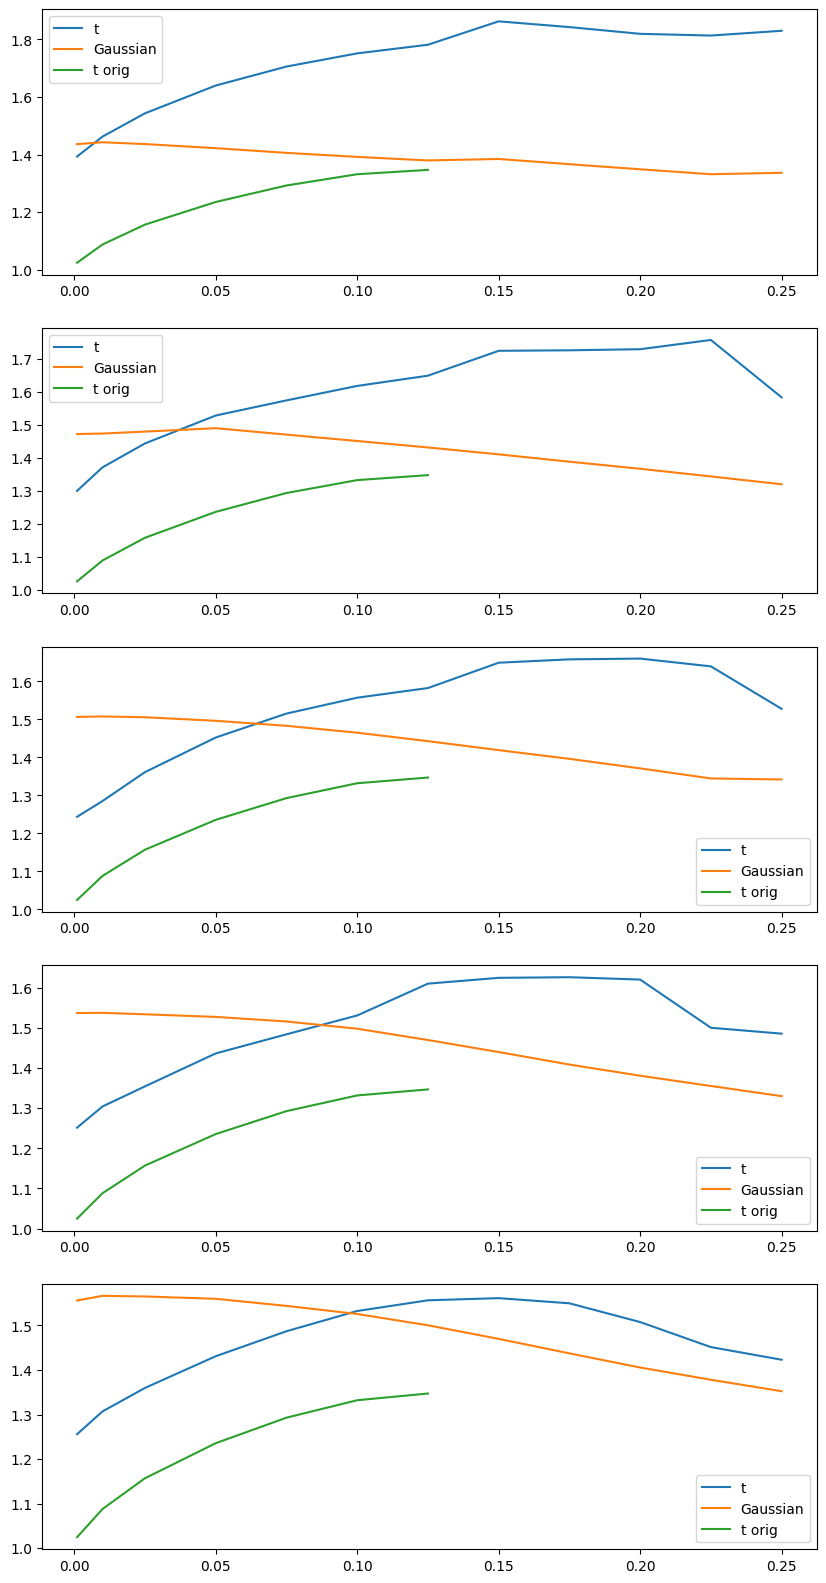

In [47]:
t_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_50.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['vars_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['vars_s'][cnt]))
    
    n_port.append(mean_mdd_n)


    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['vars_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)




fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')

    ax[cnt].legend()


Compare temporal

In [58]:


with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50.pkl', 'rb') as handle:
    t_port_ew = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50_ridge.pkl', 'rb') as handle:
    t_port_ridge = pickle.load(handle)


with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50_global-reconstruction.pkl', 'rb') as handle:
    t_port_gr = pickle.load(handle)

mean_mdd_ew = []
for cnt, alpha in enumerate(t_port_ew['alphas']):
    mean_mdd_ew.append(np.mean(t_port_ew['vars_s'][cnt]))
mean_mdd_ridge = []
for cnt, alpha in enumerate(t_port_ridge['alphas']):
    mean_mdd_ridge.append(np.mean(t_port_ridge['vars_s'][cnt]))
mean_mdd_gr = []
for cnt, alpha in enumerate(t_port_gr['alphas']):
    mean_mdd_gr.append(np.mean(t_port_gr['vars_s'][cnt]))


fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(t_port_ew['alphas'], mean_mdd_ew, label = f'ew')
ax.plot(t_port_ridge['alphas'], mean_mdd_ridge, label = f'ridge')
ax.plot(t_port_gr['alphas'], mean_mdd_gr, label = f'gr')


ax.legend()

FileNotFoundError: [Errno 2] No such file or directory: '../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_50_ridge.pkl'

### Plot return

Static return

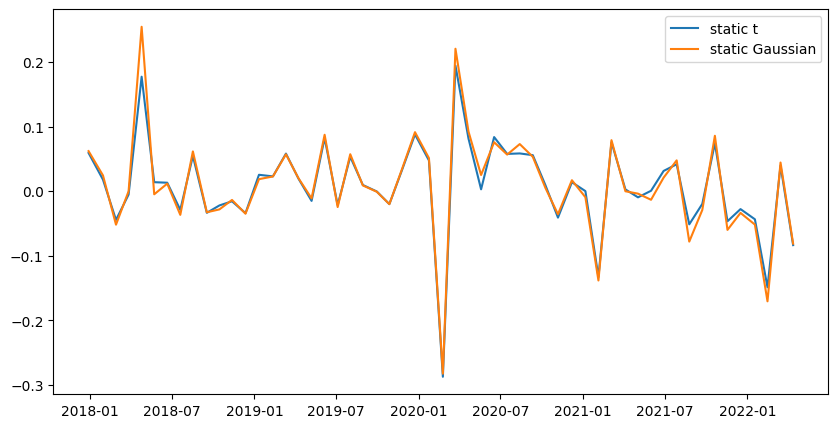

In [20]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

k = 1

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_t_port['time_change'], static_t_port['rs_s'][k], label = 'static t')
ax.plot(static_gaussian_port['time_change'], static_gaussian_port['rs_s'][k], label = 'static Gaussian')
#ax.plot(static_gt_port['time_change'][:len(static_gt_port['rs_s'][0])], static_gt_port['rs_s'][0], label = 'Group t')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

static return per alpha

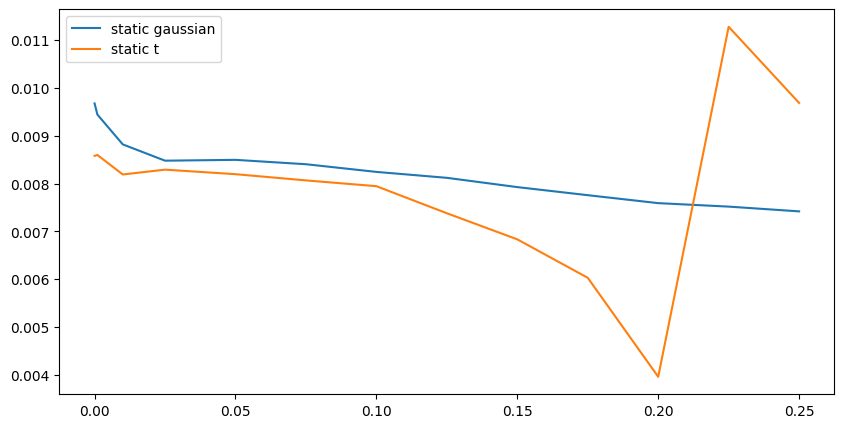

In [21]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['rs_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['rs_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()




Dynamic

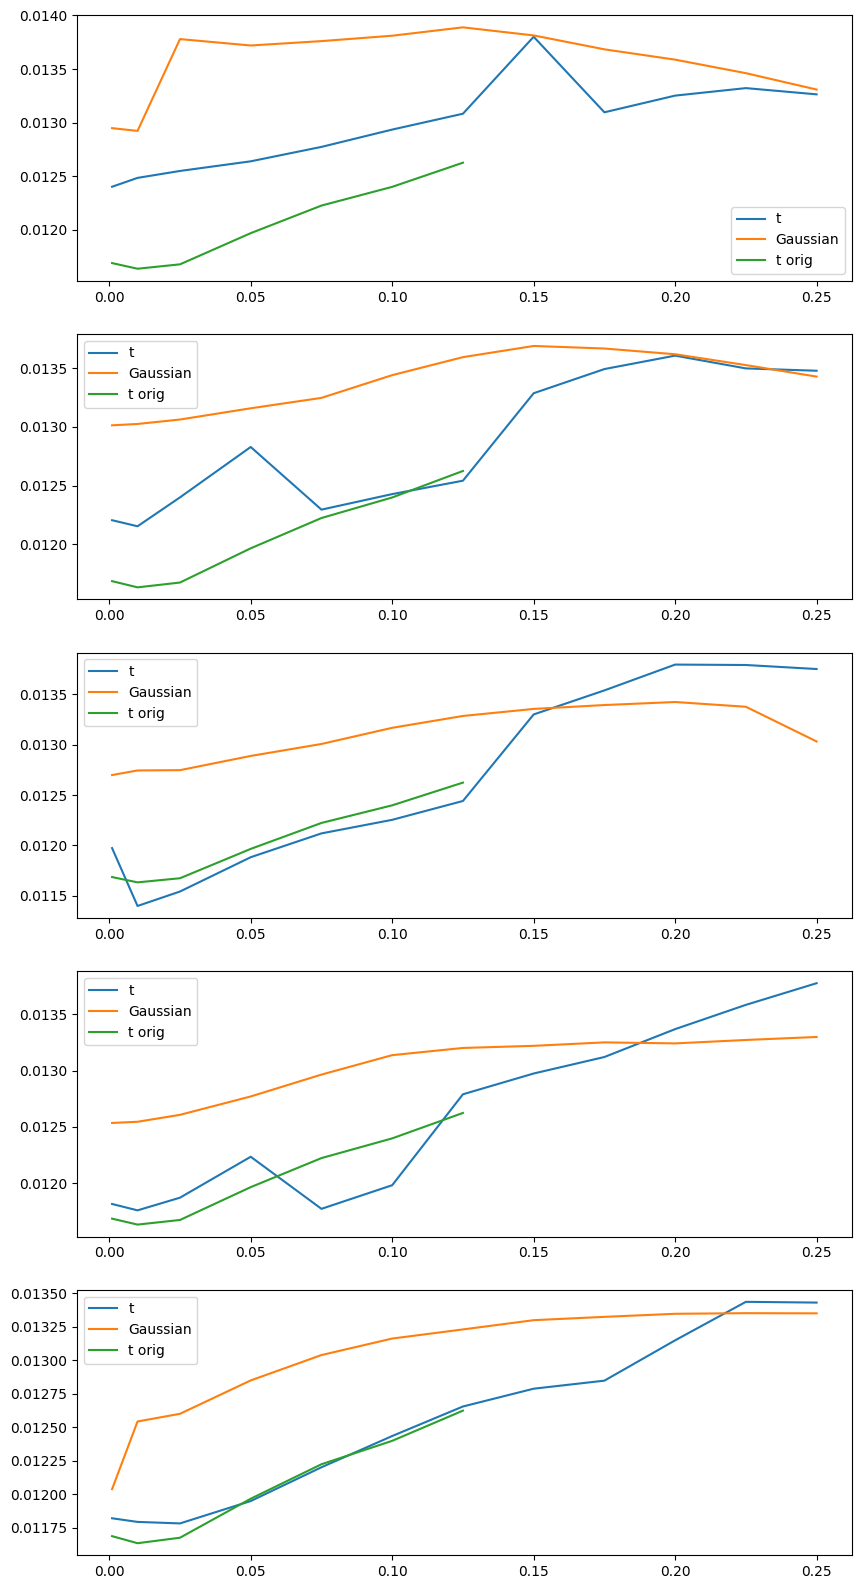

In [48]:
t_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_50.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['rs_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['rs_s'][cnt]))
    
    n_port.append(mean_mdd_n)


    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['rs_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)




fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')

    ax[cnt].legend()


### Plot sharpe

static sharpe

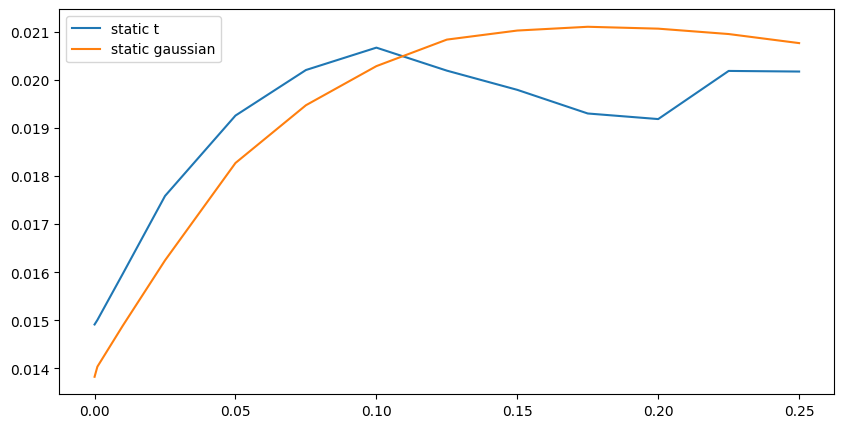

In [35]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['sharpes_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['sharpes_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.legend()





dynamic

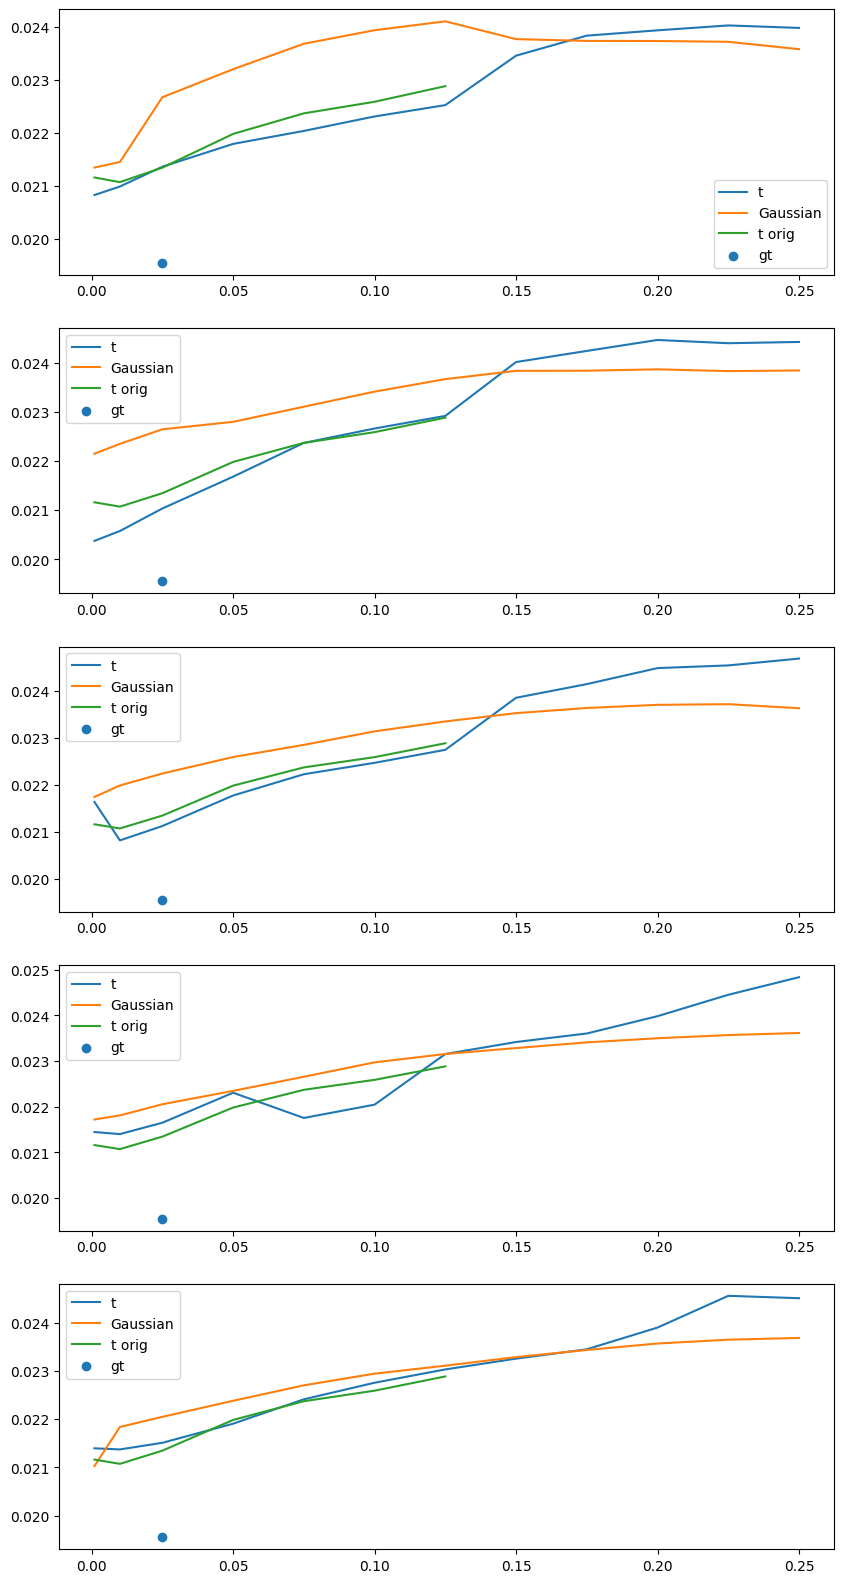

In [55]:
t_port = []
gt_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_50.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['sharpes_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['sharpes_s'][cnt]))
    
    n_port.append(mean_mdd_n)


    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['sharpes_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)

    with open(f'../data/case_study_etf/group-t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        gt_port1 = pickle.load(handle)
    mean_mdd_gt = []
    for cnt, alpha in enumerate(gt_port1['alphas']):
        mean_mdd_gt.append(np.mean(gt_port1['sharpes_s'][cnt]))
    gt_port.append(mean_mdd_gt)






fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')
    ax[cnt].scatter(gt_port1['alphas'][:len(gt_port[cnt])], gt_port[cnt], label = f'gt')

    ax[cnt].legend()


### Plot omegas

static

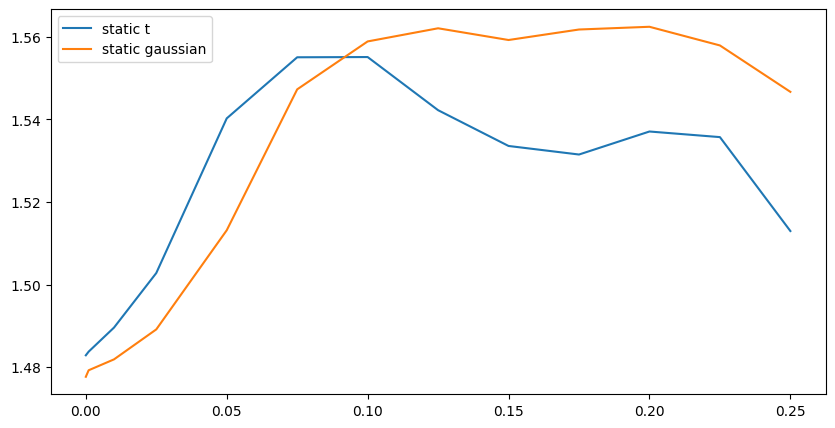

In [31]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['omegas_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['omegas_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.legend()





dynamic

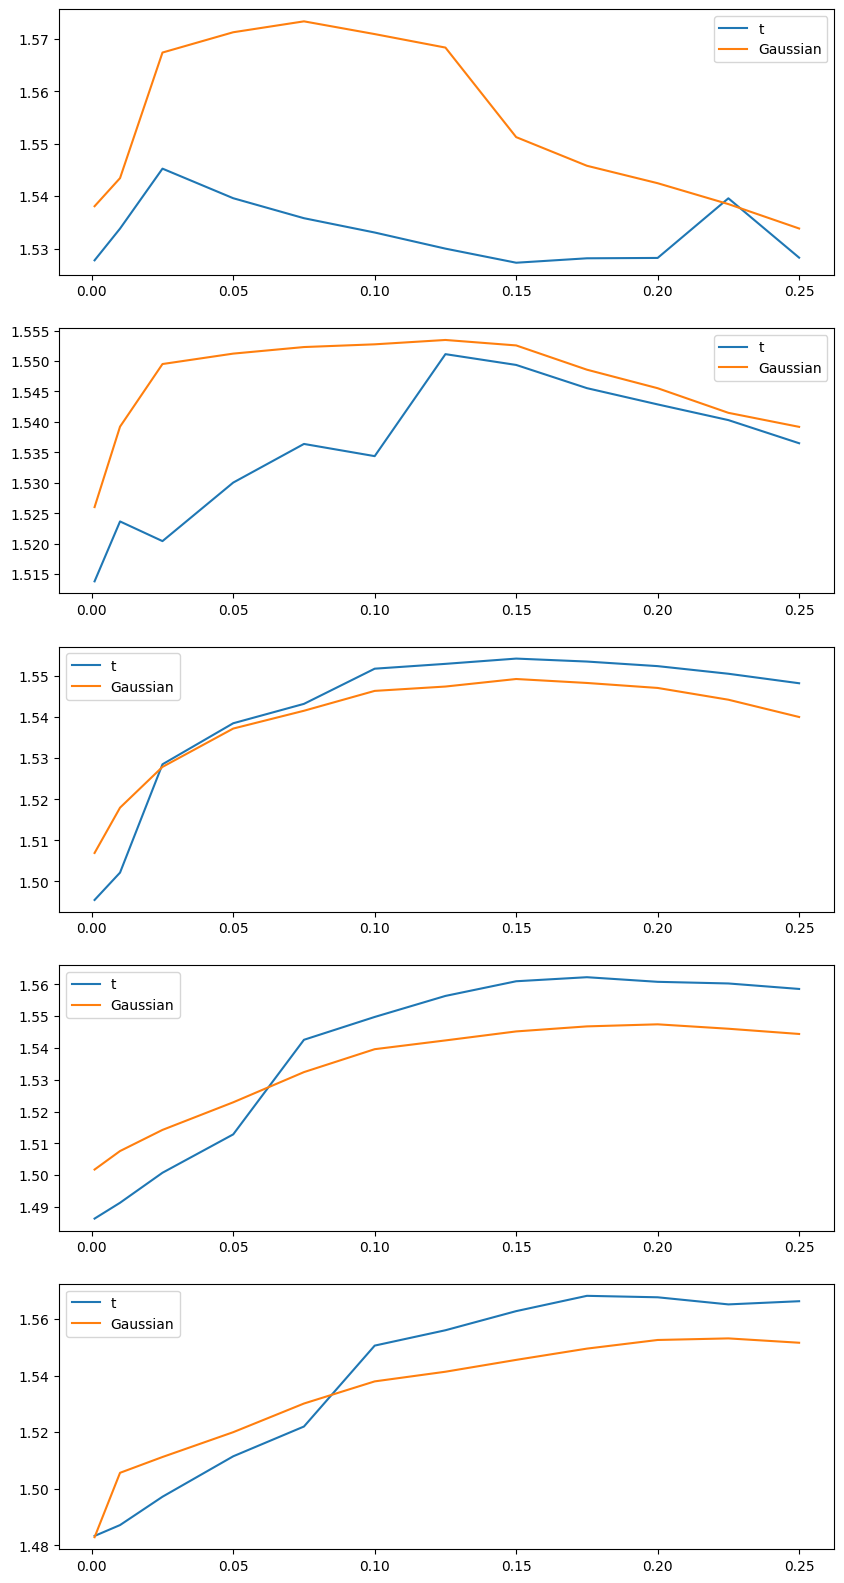

In [36]:
t_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['omegas_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['omegas_s'][cnt]))
    
    n_port.append(mean_mdd_n)


fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')

    ax[cnt].legend()

## Plot likelihhods

In [24]:
static_gaussian_port.keys()

dict_keys(['alphas', 'time_index', 'time_change', 'time_forecast', 'ticker_list', 'groups', 'price', 'X', 'l', 'obs_per_graph', 'gammas', 'Ss', 'Cs', 'tol', 'max_iter', 'ebics', 'thetas', 'nus', 'fro_norms', 'mus', 'sharpes_s', 'mdds_s', 'ws_s', 'mus_s', 'vars_s', 'rs_s', 'omegas_s', 'port_price_s', 'sigmas_s', 'sharpes_m', 'mdds_m', 'ws_m', 'mus_m', 'vars_m', 'rs_m', 'omegas_m', 'port_price_m', 'sigmas_m'])

In [23]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['likelihoods'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['likelihoods'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.legend()



KeyError: 'likelihoods'

In [178]:
import requests
response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" )
ticker_data = pd.read_html(response.content)[0]
ticker_data['group'] = 0
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2


rndstate = np.random.RandomState(6)
index = rndstate.choice(np.array(range(500)),size = 30,replace=False)
ticker_list = np.array(ticker_data['Symbol'].iloc[index]).tolist()
groups_according_to_ticker = np.array(ticker_data['group'].iloc[index])

start_date= "2016-01-01"
end_date="2023-02-01"

import yfinance as yf
data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

# reorder groups according to log_returns scaled as they are in alphabetical order
groups = np.array([j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[*********************100%***********************]  30 of 30 completed


In [180]:
log_returns_scaled.columns

Index(['A', 'AES', 'APD', 'BA', 'BEN', 'BRO', 'CMS', 'CVS', 'EQIX', 'EQR',
       'FDX', 'FIS', 'GRMN', 'GS', 'INTC', 'IT', 'IVZ', 'MCHP', 'META', 'MPC',
       'MSFT', 'MTCH', 'NOC', 'PCAR', 'RHI', 'SIVB', 'SYF', 'SYK', 'TXT',
       'ZBRA'],
      dtype='object')

In [181]:
sorted(zip(ticker_list, groups_according_to_ticker))

[('A', 2),
 ('AES', 0),
 ('APD', 0),
 ('BA', 0),
 ('BEN', 2),
 ('BRO', 2),
 ('CMS', 0),
 ('CVS', 2),
 ('EQIX', 2),
 ('EQR', 2),
 ('FDX', 0),
 ('FIS', 2),
 ('GRMN', 1),
 ('GS', 2),
 ('INTC', 2),
 ('IT', 2),
 ('IVZ', 2),
 ('MCHP', 2),
 ('META', 1),
 ('MPC', 0),
 ('MSFT', 2),
 ('MTCH', 1),
 ('NOC', 0),
 ('PCAR', 0),
 ('RHI', 0),
 ('SIVB', 2),
 ('SYF', 2),
 ('SYK', 2),
 ('TXT', 0),
 ('ZBRA', 2)]

In [179]:
[j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))]  

[2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2]

In [160]:
start_date= "2016-01-01"
end_date="2023-02-01"

import yfinance as yf
data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

[*********************100%***********************]  30 of 30 completed


In [163]:
ticker_list

['PKG',
 'BWA',
 'PNW',
 'DPZ',
 'CVX',
 'RJF',
 'POOL',
 'ED',
 'BIIB',
 'TSCO',
 'AAP',
 'FRT',
 'ROST',
 'CPT',
 'PCG',
 'PHM',
 'WYNN',
 'AEP',
 'MU',
 'SPGI',
 'WY',
 'WHR',
 'LHX',
 'OKE',
 'BMY',
 'UNP',
 'XYL',
 'GRMN',
 'CRL',
 'NWL']

In [162]:
log_returns_scaled.columns

Index(['AAP', 'AEP', 'BIIB', 'BMY', 'BWA', 'CPT', 'CRL', 'CVX', 'DPZ', 'ED',
       'FRT', 'GRMN', 'LHX', 'MU', 'NWL', 'OKE', 'PCG', 'PHM', 'PKG', 'PNW',
       'POOL', 'RJF', 'ROST', 'SPGI', 'TSCO', 'UNP', 'WHR', 'WY', 'WYNN',
       'XYL'],
      dtype='object')

In [165]:
log_returns_scaled.columns

Index(['AAP', 'AEP', 'BIIB', 'BMY', 'BWA', 'CPT', 'CRL', 'CVX', 'DPZ', 'ED',
       'FRT', 'GRMN', 'LHX', 'MU', 'NWL', 'OKE', 'PCG', 'PHM', 'PKG', 'PNW',
       'POOL', 'RJF', 'ROST', 'SPGI', 'TSCO', 'UNP', 'WHR', 'WY', 'WYNN',
       'XYL'],
      dtype='object')

In [167]:
sorted(zip(ticker_list, groups))

[('AAP', 1),
 ('AEP', 0),
 ('BIIB', 2),
 ('BMY', 2),
 ('BWA', 1),
 ('CPT', 2),
 ('CRL', 2),
 ('CVX', 0),
 ('DPZ', 1),
 ('ED', 0),
 ('FRT', 2),
 ('GRMN', 1),
 ('LHX', 0),
 ('MU', 2),
 ('NWL', 1),
 ('OKE', 0),
 ('PCG', 0),
 ('PHM', 1),
 ('PKG', 0),
 ('PNW', 0),
 ('POOL', 1),
 ('RJF', 2),
 ('ROST', 1),
 ('SPGI', 2),
 ('TSCO', 1),
 ('UNP', 0),
 ('WHR', 1),
 ('WY', 2),
 ('WYNN', 1),
 ('XYL', 0)]

In [164]:
np.where(log_returns_scaled.columns == ticker_list)

(array([25], dtype=int64),)

### MMD between matrices

In [104]:
t_port['Ss'][0]

[array([[ 0.40694009,  0.11268457,  0.07256155,  0.07668409,  0.10282186,
          0.11503969,  0.13685837,  0.17818374,  0.07152661,  0.12653499,
          0.15538891],
        [ 0.11268457,  0.46395931,  0.24139761,  0.29887974,  0.2767459 ,
          0.22969721,  0.09683661,  0.01449951,  0.13444185,  0.21875873,
          0.28061071],
        [ 0.07256155,  0.24139761,  0.66990648,  0.21940584,  0.16885511,
          0.09204396,  0.03918344, -0.00427547,  0.0546681 ,  0.11072932,
          0.17285539],
        [ 0.07668409,  0.29887974,  0.21940584,  0.62441271,  0.30743875,
          0.24666341,  0.07885716, -0.07674053,  0.1670924 ,  0.25059681,
          0.31052125],
        [ 0.10282186,  0.2767459 ,  0.16885511,  0.30743875,  0.3510012 ,
          0.23291782,  0.10182053,  0.02057851,  0.14620386,  0.220679  ,
          0.2546925 ],
        [ 0.11503969,  0.22969721,  0.09204396,  0.24666341,  0.23291782,
          0.4290805 ,  0.13143337,  0.0354417 ,  0.19789067,  0.2646867

In [16]:
gaussian_port['Ss'][0][25]

array([[0.58858782, 0.24688863, 0.18511434, 0.23768209, 0.275686  ,
        0.34048645, 0.32991663, 0.31592916, 0.30484103, 0.30419523,
        0.3034444 ],
       [0.24688863, 0.93248292, 0.71641268, 0.69651224, 0.77461315,
        0.73093537, 0.36336424, 0.07279198, 0.45349959, 0.60361756,
        0.69193236],
       [0.18511434, 0.71641268, 1.53845454, 0.83552787, 0.81694025,
        0.80647774, 0.3166719 , 0.01767632, 0.49555379, 0.66588279,
        0.84322443],
       [0.23768209, 0.69651224, 0.83552787, 1.0920955 , 0.8081374 ,
        0.83106202, 0.38155678, 0.05753096, 0.52783424, 0.6892334 ,
        0.80713234],
       [0.275686  , 0.77461315, 0.81694025, 0.8081374 , 0.98310879,
        0.8310421 , 0.38741279, 0.0768172 , 0.50493322, 0.68991031,
        0.7949517 ],
       [0.34048645, 0.73093537, 0.80647774, 0.83106202, 0.8310421 ,
        1.31901089, 0.41997633, 0.11337453, 0.65518485, 0.88377904,
        0.94986228],
       [0.32991663, 0.36336424, 0.3166719 , 0.38155678, 0.

In [30]:
import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(t_port['Ss'][0][i]) for i in range(20)], G2 = [nx.from_numpy_array(gaussian_port['Ss'][0][i]) for i in range(20)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 6, c = 0.00008, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.383}


<AxesSubplot:>

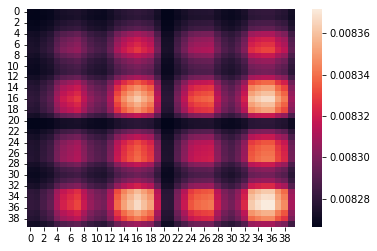

In [31]:
import seaborn as sns
sns.heatmap(MMD_out.K)

In [51]:
len(gt_port['Ss'][0])

21

In [57]:
gt_port['thetas'][0][-1]

array([[[ 4.08608605, -0.13050656,  0.16215641, ..., -0.0452828 ,
         -0.89832004, -0.13209369],
        [-0.13050656,  4.4375643 , -0.61803935, ...,  0.20490182,
         -0.2447168 , -0.15044082],
        [ 0.16215641, -0.61803935,  1.59469283, ..., -0.22213131,
         -0.27891629, -0.08004994],
        ...,
        [-0.0452828 ,  0.20490182, -0.22213131, ...,  4.68138873,
         -0.29033703,  0.04825175],
        [-0.89832004, -0.2447168 , -0.27891629, ..., -0.29033703,
          6.53040941, -0.83346136],
        [-0.13209369, -0.15044082, -0.08004994, ...,  0.04825175,
         -0.83346136,  2.41302645]],

       [[ 4.08561824, -0.1315588 ,  0.16037965, ..., -0.04555137,
         -0.89875567, -0.13300222],
        [-0.1315588 ,  4.43724261, -0.62052697, ...,  0.20382897,
         -0.24817573, -0.15265228],
        [ 0.16037965, -0.62052697,  1.59205182, ..., -0.22349923,
         -0.28106878, -0.0819152 ],
        ...,
        [-0.04555137,  0.20382897, -0.22349923, ...,  

In [71]:
import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(t_port['thetas'][0][i][-1]) for i in range(10,20)], G2 = [nx.from_numpy_array(gaussian_port['thetas'][0][i][-1]) for i in range(10,20)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 5, c = 0.005, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.006}


In [75]:
gt_port['Ss'][0][0]

array([[ 0.42465705,  0.10508556,  0.07127481,  0.07225937,  0.0933854 ,
         0.11107053,  0.13074265,  0.17869316,  0.06384055,  0.11636746,
         0.14856416],
       [ 0.10508556,  0.44345818,  0.23723943,  0.28703186,  0.25657384,
         0.21427276,  0.08065005,  0.00468791,  0.123169  ,  0.19549531,
         0.26372837],
       [ 0.07127481,  0.23723943,  0.6615836 ,  0.21255977,  0.16038563,
         0.08775042,  0.02751214, -0.00831321,  0.04989833,  0.09666234,
         0.164366  ],
       [ 0.07225937,  0.28703186,  0.21255977,  0.64123282,  0.29305948,
         0.24208324,  0.0660708 , -0.08765702,  0.17302809,  0.23510618,
         0.29881118],
       [ 0.0933854 ,  0.25657384,  0.16038563,  0.29305948,  0.32141092,
         0.21535788,  0.08586058,  0.01022409,  0.13509998,  0.19606624,
         0.2331417 ],
       [ 0.11107053,  0.21427276,  0.08775042,  0.24208324,  0.21535788,
         0.43134888,  0.12075685,  0.0270984 ,  0.19441904,  0.24728226,
         0.303

In [125]:
def off_zero(X):
    X_TMP = X.copy()

    np.fill_diagonal(X_TMP, 0)
    return X_TMP

import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(off_zero(t_port['Ss'][0][i])) for i in range(30)], G2 = [nx.from_numpy_array(off_zero(gaussian_port['Ss'][0][i])) for i in range(30)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 5, c = 0.00005, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.358}


In [91]:
MMD_out.sample_mmd

{'MMD_u': 1.5366328264106166e-05}